# Import Library

In [121]:
# Import library yang akan digunakan
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from numpy import log
import pmdarima as pm

# Import min-max scaling function
from sklearn.preprocessing import MinMaxScaler

# Import keras lstm model
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Bidirectional, GRU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from pmdarima import auto_arima

# Metrics
from sklearn import metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error, r2_score, root_mean_squared_error
from sklearn.linear_model import LinearRegression

# Load Data

In [116]:
df_sales = pd.read_csv('./store5.csv')
df_sales['date']=pd.to_datetime(df_sales['date'])
df_sales['Monthly'] = df_sales['date'].dt.to_period('M')
df_sales

id       date  store_nbr                      family     sales  \
0         1452 2013-01-01          5                  AUTOMOTIVE     0.000   
1         1453 2013-01-01          5                   BABY CARE     0.000   
2         1454 2013-01-01          5                      BEAUTY     0.000   
3         1455 2013-01-01          5                   BEVERAGES     0.000   
4         1456 2013-01-01          5                       BOOKS     0.000   
...        ...        ...        ...                         ...       ...   
55567  3000586 2017-08-15          5                     POULTRY   241.011   
55568  3000587 2017-08-15          5              PREPARED FOODS    52.121   
55569  3000588 2017-08-15          5                     PRODUCE  1357.823   
55570  3000589 2017-08-15          5  SCHOOL AND OFFICE SUPPLIES     0.000   
55571  3000590 2017-08-15          5                     SEAFOOD     9.669   

       onpromotion  dcoilwtico  Monthly  
0                0         NaN  2013-01  
1                0         NaN  2013-01  
2                0         NaN  2013-01  
3                0         NaN  2013-01  
4                0         NaN  2013-01  
...            ...         ...      ...  
55567            1       47.57  2017-08  
55568            0       47.57  2017-08  
55569            4       47.57  2017-08  
55570            0       47.57  2017-08  
55571            0       47.57  2017-08  

[55572 rows x 8 columns]

In [117]:
#group by month
df_sales_monthly = df_sales.groupby(['Monthly','family'])['sales'].sum().reset_index()
df_sales_monthly['Monthly'] = df_sales_monthly['Monthly'].dt.to_timestamp()
df_sales_monthly.index=df_sales_monthly['Monthly']
df_sales_monthly

Monthly                      family        sales
Monthly                                                       
2013-01-01 2013-01-01                  AUTOMOTIVE    134.00000
2013-01-01 2013-01-01                   BABY CARE      0.00000
2013-01-01 2013-01-01                      BEAUTY    125.00000
2013-01-01 2013-01-01                   BEVERAGES  22187.00000
2013-01-01 2013-01-01                       BOOKS      0.00000
...               ...                         ...          ...
2017-08-01 2017-08-01                     POULTRY   3478.34399
2017-08-01 2017-08-01              PREPARED FOODS    908.20900
2017-08-01 2017-08-01                     PRODUCE  23991.32390
2017-08-01 2017-08-01  SCHOOL AND OFFICE SUPPLIES     14.00000
2017-08-01 2017-08-01                     SEAFOOD    144.30100

[1848 rows x 3 columns]

In [118]:
#set index daily

df_sales['date'] = pd.to_datetime(df_sales['date'])
df_sales.index=df_sales['date']
df_sales=df_sales.drop(['id','store_nbr','Monthly'],axis=1)
df_sales

date                      family     sales  onpromotion  \
date                                                                       
2013-01-01 2013-01-01                  AUTOMOTIVE     0.000            0   
2013-01-01 2013-01-01                   BABY CARE     0.000            0   
2013-01-01 2013-01-01                      BEAUTY     0.000            0   
2013-01-01 2013-01-01                   BEVERAGES     0.000            0   
2013-01-01 2013-01-01                       BOOKS     0.000            0   
...               ...                         ...       ...          ...   
2017-08-15 2017-08-15                     POULTRY   241.011            1   
2017-08-15 2017-08-15              PREPARED FOODS    52.121            0   
2017-08-15 2017-08-15                     PRODUCE  1357.823            4   
2017-08-15 2017-08-15  SCHOOL AND OFFICE SUPPLIES     0.000            0   
2017-08-15 2017-08-15                     SEAFOOD     9.669            0   

            dcoilwtico  
date                    
2013-01-01         NaN  
2013-01-01         NaN  
2013-01-01         NaN  
2013-01-01         NaN  
2013-01-01         NaN  
...                ...  
2017-08-15       47.57  
2017-08-15       47.57  
2017-08-15       47.57  
2017-08-15       47.57  
2017-08-15       47.57  

[55572 rows x 5 columns]

# EDA

In [156]:
df_try = df_sales.copy()

df_try['date_num'] = pd.to_datetime(df_try['date']).map(pd.Timestamp.toordinal)

#lag
lags = [1, 2, 3, 4, 5, 6, 7]  # Define lag periods
for lag in lags:
    df_try[f'Lag_{lag}'] = df_try['sales'].shift(lag)


#oil price
known_data = df_try.dropna()
missing_data = df_try[df_try['dcoilwtico'].isna()]

# Train Linear Regression model
model_regression = LinearRegression()
model_regression.fit(known_data[['date_num']], known_data['dcoilwtico'])

# Predict missing values
df_try.loc[df_try['dcoilwtico'].isna(), 'dcoilwtico'] = model_regression.predict(missing_data[['date_num']])

lags = [1, 2, 3]  # Define lag periods
for lag in lags:
    df_try[f'Lag_{lag}'] = df_try['sales'].shift(lag)

df_try = df_try.drop(['date_num'],axis=1)

# Print updated DataFrame
print(df_try)


                 date                      family     sales  onpromotion  \
date                                                                       
2013-01-01 2013-01-01                  AUTOMOTIVE     0.000            0   
2013-01-01 2013-01-01                   BABY CARE     0.000            0   
2013-01-01 2013-01-01                      BEAUTY     0.000            0   
2013-01-01 2013-01-01                   BEVERAGES     0.000            0   
2013-01-01 2013-01-01                       BOOKS     0.000            0   
...               ...                         ...       ...          ...   
2017-08-15 2017-08-15                     POULTRY   241.011            1   
2017-08-15 2017-08-15              PREPARED FOODS    52.121            0   
2017-08-15 2017-08-15                     PRODUCE  1357.823            4   
2017-08-15 2017-08-15  SCHOOL AND OFFICE SUPPLIES     0.000            0   
2017-08-15 2017-08-15                     SEAFOOD     9.669            0   

           

<Axes: title={'center': 'Lag7'}, xlabel='date'>

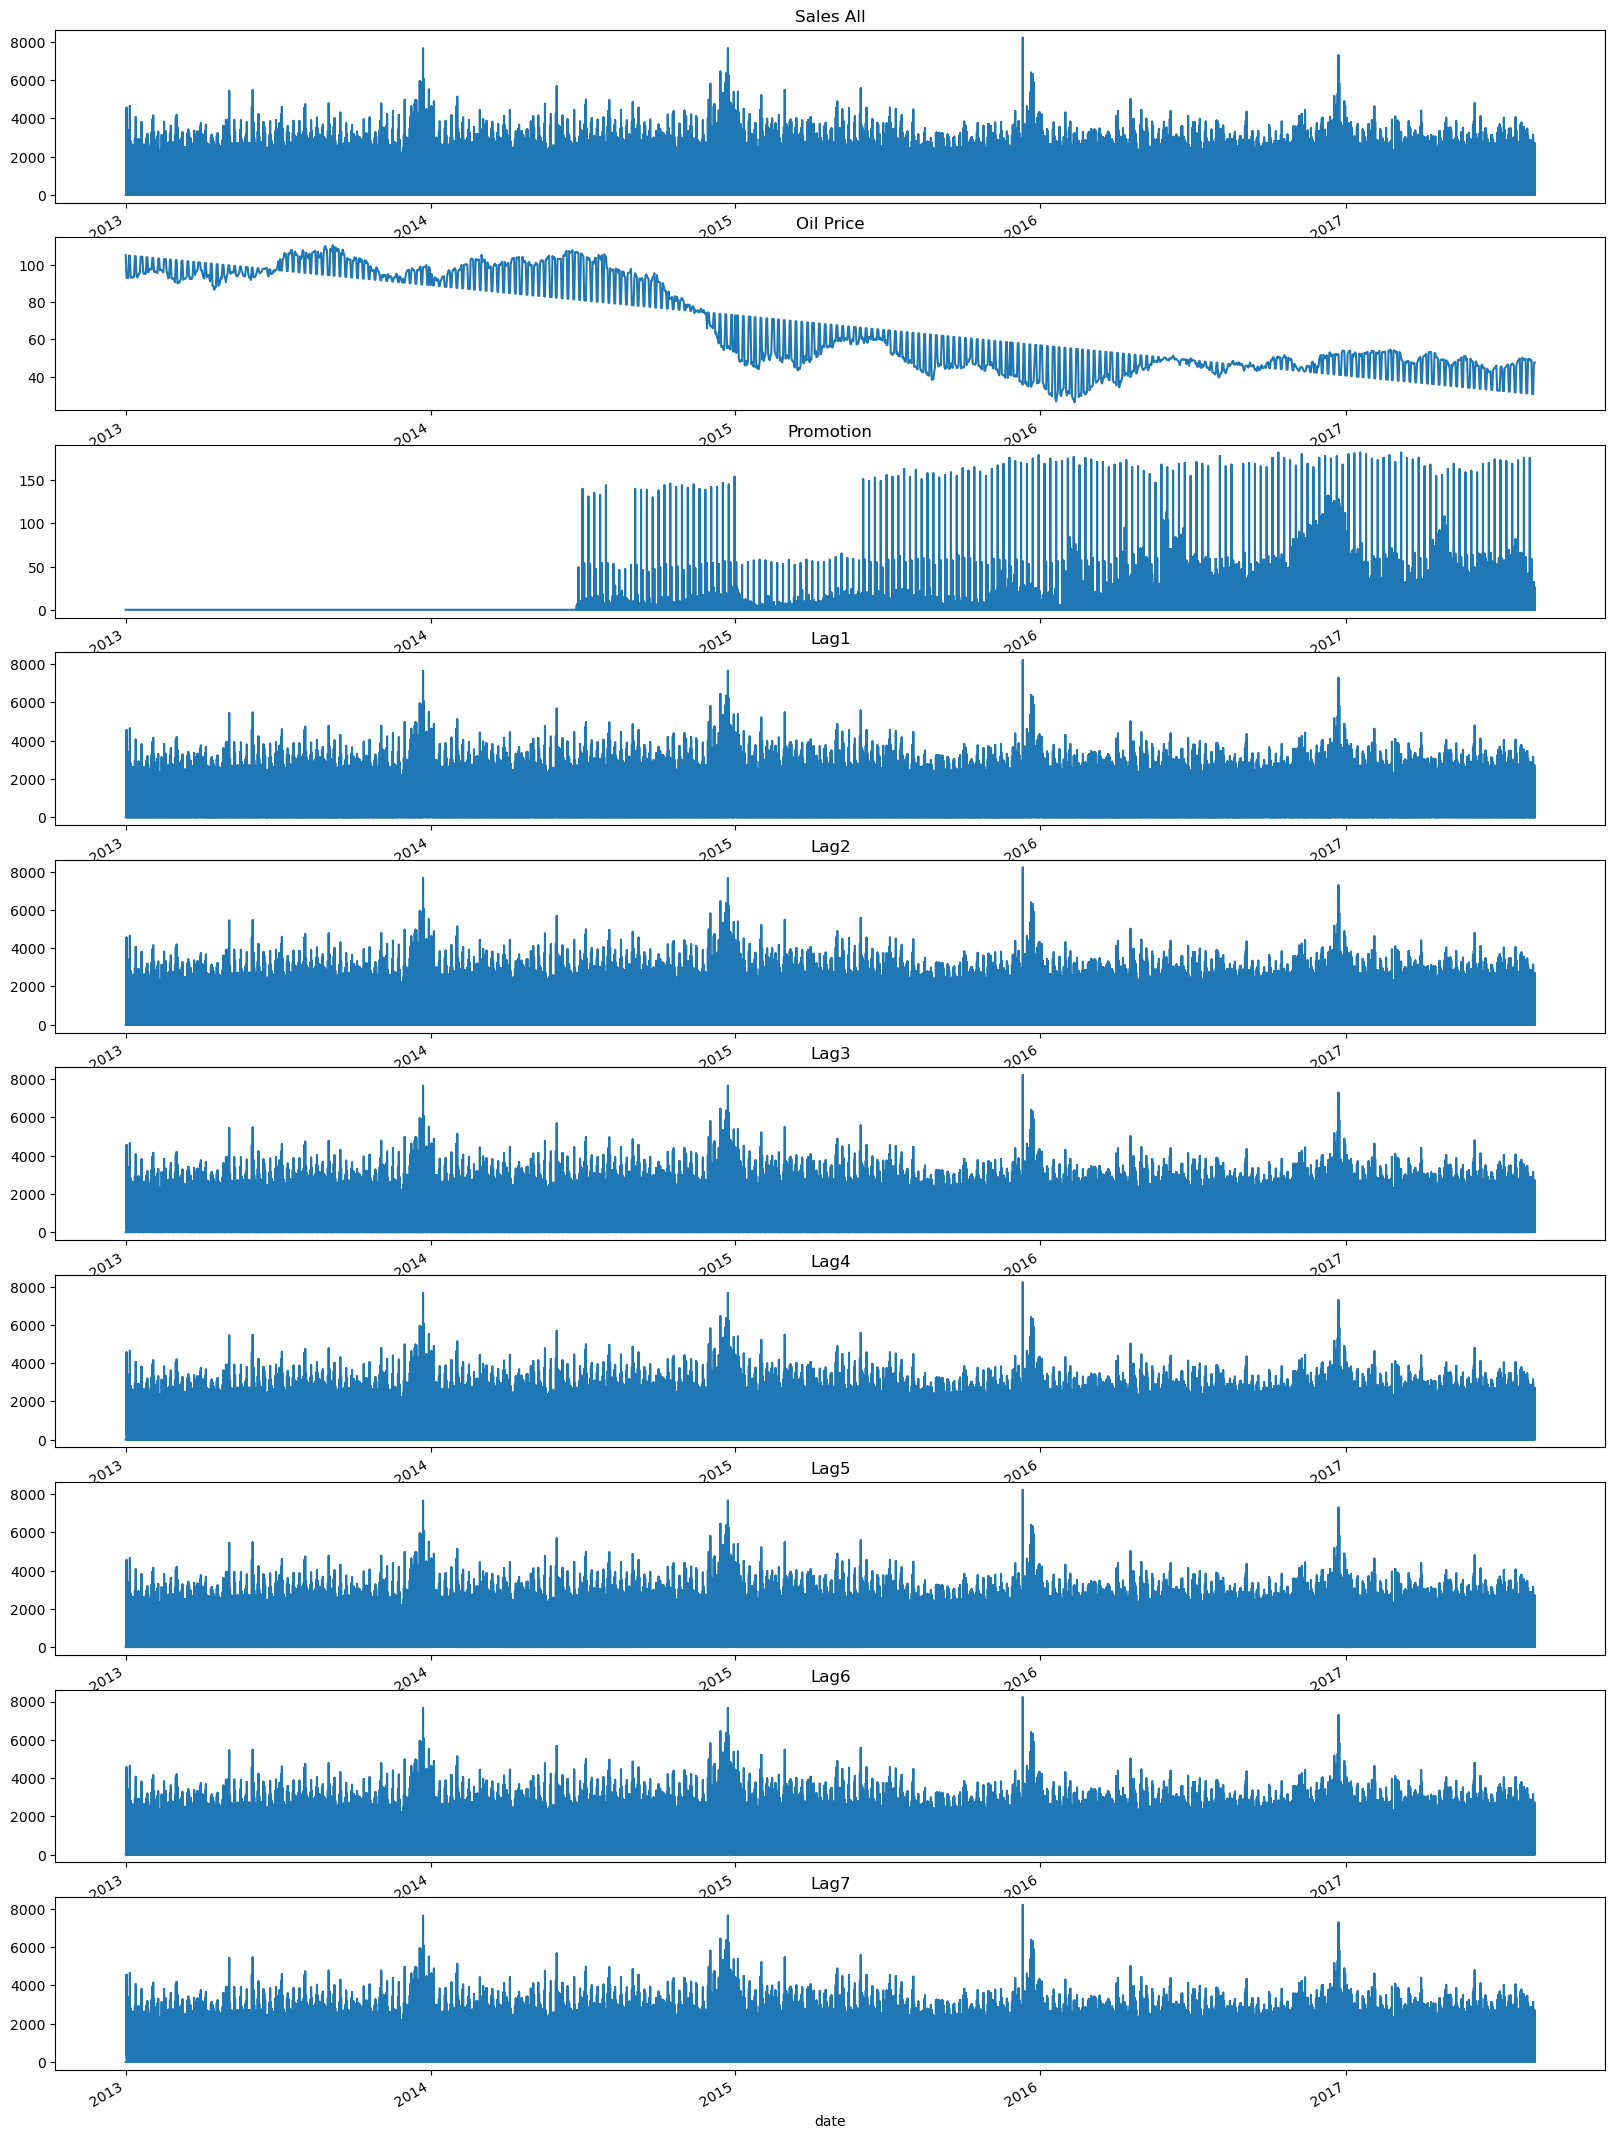

In [178]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(10, 1, figsize=(20, 30))
df_try['sales'].plot(ax=ax1, title='Sales All')
df_try['dcoilwtico'].plot(ax=ax2, title='Oil Price')
df_try['onpromotion'].plot(ax=ax3, title='Promotion')
df_try['Lag_1'].plot(ax=ax4, title='Lag1')
df_try['Lag_2'].plot(ax=ax5, title='Lag2')
df_try['Lag_3'].plot(ax=ax6, title='Lag3')
df_try['Lag_4'].plot(ax=ax7, title='Lag4')
df_try['Lag_5'].plot(ax=ax8, title='Lag5')
df_try['Lag_6'].plot(ax=ax9, title='Lag6')
df_try['Lag_7'].plot(ax=ax10, title='Lag7')


In [7]:
df_sales_family = df_sales.groupby('family')['sales'].agg(['mean','sum']).reset_index()
df_sales_family=df_sales_family.sort_values(by=['sum'],ascending=False)
df_sales_family

family         mean           sum
12                   GROCERY I  3125.107873  5.262682e+06
3                    BEVERAGES  1504.650238  2.533831e+06
7                     CLEANING   990.349169  1.667748e+06
30                     PRODUCE   981.937208  1.653582e+06
8                        DAIRY   517.388955  8.712830e+05
5                 BREAD/BAKERY   381.742610  6.428546e+05
24                       MEATS   283.316157  4.771044e+05
25               PERSONAL CARE   267.319477  4.501660e+05
28                     POULTRY   249.186681  4.196304e+05
9                         DELI   246.597982  4.152710e+05
11                FROZEN FOODS   160.136102  2.696692e+05
18                   HOME CARE   142.092043  2.392830e+05
10                        EGGS   113.331948  1.908510e+05
29              PREPARED FOODS    87.880718  1.479911e+05
22            LIQUOR,WINE,BEER    65.566508  1.104140e+05
16         HOME AND KITCHEN II    22.112827  3.723800e+04
13                  GROCERY II    19.739311  3.324100e+04
21                    LINGERIE    18.741686  3.156100e+04
15          HOME AND KITCHEN I    17.878266  3.010700e+04
6                  CELEBRATION    15.543943  2.617600e+04
32                     SEAFOOD    13.277312  2.235899e+04
19                  LADIESWEAR     8.796318  1.481300e+04
0                   AUTOMOTIVE     5.459620  9.194000e+03
2                       BEAUTY     5.156770  8.684000e+03
27     PLAYERS AND ELECTRONICS     4.764846  8.024000e+03
23                   MAGAZINES     3.900831  6.569000e+03
20             LAWN AND GARDEN     2.951306  4.970000e+03
26                PET SUPPLIES     1.899644  3.199000e+03
14                    HARDWARE     1.024347  1.725000e+03
17             HOME APPLIANCES     0.549881  9.260000e+02
31  SCHOOL AND OFFICE SUPPLIES     0.482779  8.130000e+02
4                        BOOKS     0.136580  2.300000e+02
1                    BABY CARE     0.127672  2.150000e+02

In [8]:
df_sales['family'].value_counts()

family
AUTOMOTIVE                    1684
HOME APPLIANCES               1684
SCHOOL AND OFFICE SUPPLIES    1684
PRODUCE                       1684
PREPARED FOODS                1684
POULTRY                       1684
PLAYERS AND ELECTRONICS       1684
PET SUPPLIES                  1684
PERSONAL CARE                 1684
MEATS                         1684
MAGAZINES                     1684
LIQUOR,WINE,BEER              1684
LINGERIE                      1684
LAWN AND GARDEN               1684
LADIESWEAR                    1684
HOME CARE                     1684
HOME AND KITCHEN II           1684
BABY CARE                     1684
HOME AND KITCHEN I            1684
HARDWARE                      1684
GROCERY II                    1684
GROCERY I                     1684
FROZEN FOODS                  1684
EGGS                          1684
DELI                          1684
DAIRY                         1684
CLEANING                      1684
CELEBRATION                   1684
BREAD/BAKERY 

In [9]:
df_family=pd.DataFrame(df_sales_family['family'].values)
len(df_family)

33

## Define Target Variable

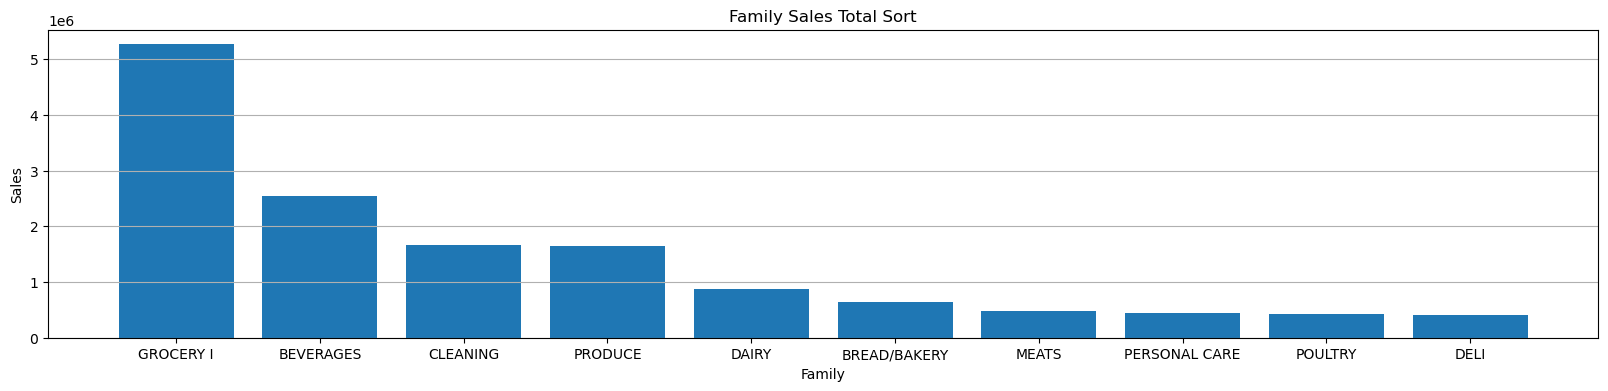

In [10]:
plt.figure(figsize=(20,4))

plt.bar(df_sales_family['family'].head(10),df_sales_family['sum'].head(10))

plt.title('Family Sales Total Sort')
plt.xlabel('Family')
plt.ylabel('Sales')
plt.grid(axis='y')

plt.show()

Selected Target variable is the highest which is GROCERY I

However it is analyzed that there are 2 family type containing 'GROCERY' which is 'GROCERY I' & 'GROCERY II'

Hence, both of the grocery family

## Explore Each Variables

In [175]:
df_try['Groceries']=np.where((df_try['family'] == 'GROCERY I') | (df_try['family'] == 'GROCERY II'),'Yes','No')
#df_sales['Groceries']=np.where((df_sales['family'] == 'GROCERY I'),'Yes','No')
df_groceries_try=df_try.loc[df_try['Groceries'] == 'Yes']
df_groceries_try=df_groceries_try.rename(columns={'date':'Date'})
df_groceries_try=df_groceries_try.groupby(df_groceries_try['Date']).agg({'sales': 'mean','onpromotion': 'mean','dcoilwtico': 'mean','Lag_1': 'mean','Lag_2': 'mean','Lag_3': 'mean','Lag_4': 'mean','Lag_5': 'mean','Lag_6': 'mean','Lag_7': 'mean'}).rename(columns={'sum':'Sales'}).reset_index()
df_groceries_try.set_index('Date',inplace=True)
df_groceries_try

sales  onpromotion  dcoilwtico      Lag_1     Lag_2     Lag_3  \
Date                                                                         
2013-01-01     0.0          0.0  105.239922     0.0000    0.0000    0.0000   
2013-01-02  2285.5          0.0   93.140000  2372.5840  216.5840  313.7385   
2013-01-03  1634.0          0.0   92.970000  1688.9970  118.9970  199.4120   
2013-01-04  1554.0          0.0   93.120000  1603.0910  131.0910  216.2040   
2013-01-05  1708.0          0.0  105.062879  1780.4550  152.9550  215.8770   
...            ...          ...         ...        ...       ...       ...   
2017-08-11  1451.5         17.5   48.810000  1485.5000  101.0000  184.6815   
2017-08-12  1249.5         15.5   30.704497  1320.1890  120.6890  122.4890   
2017-08-13  1584.0         15.5   30.660236  1604.5000   84.0000  177.4975   
2017-08-14  1367.0         16.0   47.590000  1399.0750   83.0750  145.0815   
2017-08-15  1358.5         13.0   47.570000  1372.7325   58.7325  131.4855   

               Lag_4   Lag_5  Lag_6     Lag_7  
Date                                           
2013-01-01    0.0000     0.0    0.0    0.0000  
2013-01-02  397.7385  1112.0  905.0  283.4585  
2013-01-03  322.4120   835.5  652.5  188.9435  
2013-01-04  300.2040   734.0  579.5  167.8805  
2013-01-05  322.3770   806.5  628.5  201.1430  
...              ...     ...    ...       ...  
2017-08-11  381.6815   632.0  407.0  175.5930  
2017-08-12  300.4890   559.5  354.5  135.4465  
2017-08-13  413.4975   749.5  473.5  193.2125  
2017-08-14  392.5815   628.0  352.0  210.5750  
2017-08-15  370.9855   634.0  374.5  181.2170  

[1684 rows x 10 columns]

<Axes: title={'center': 'Lag7'}, xlabel='Date'>

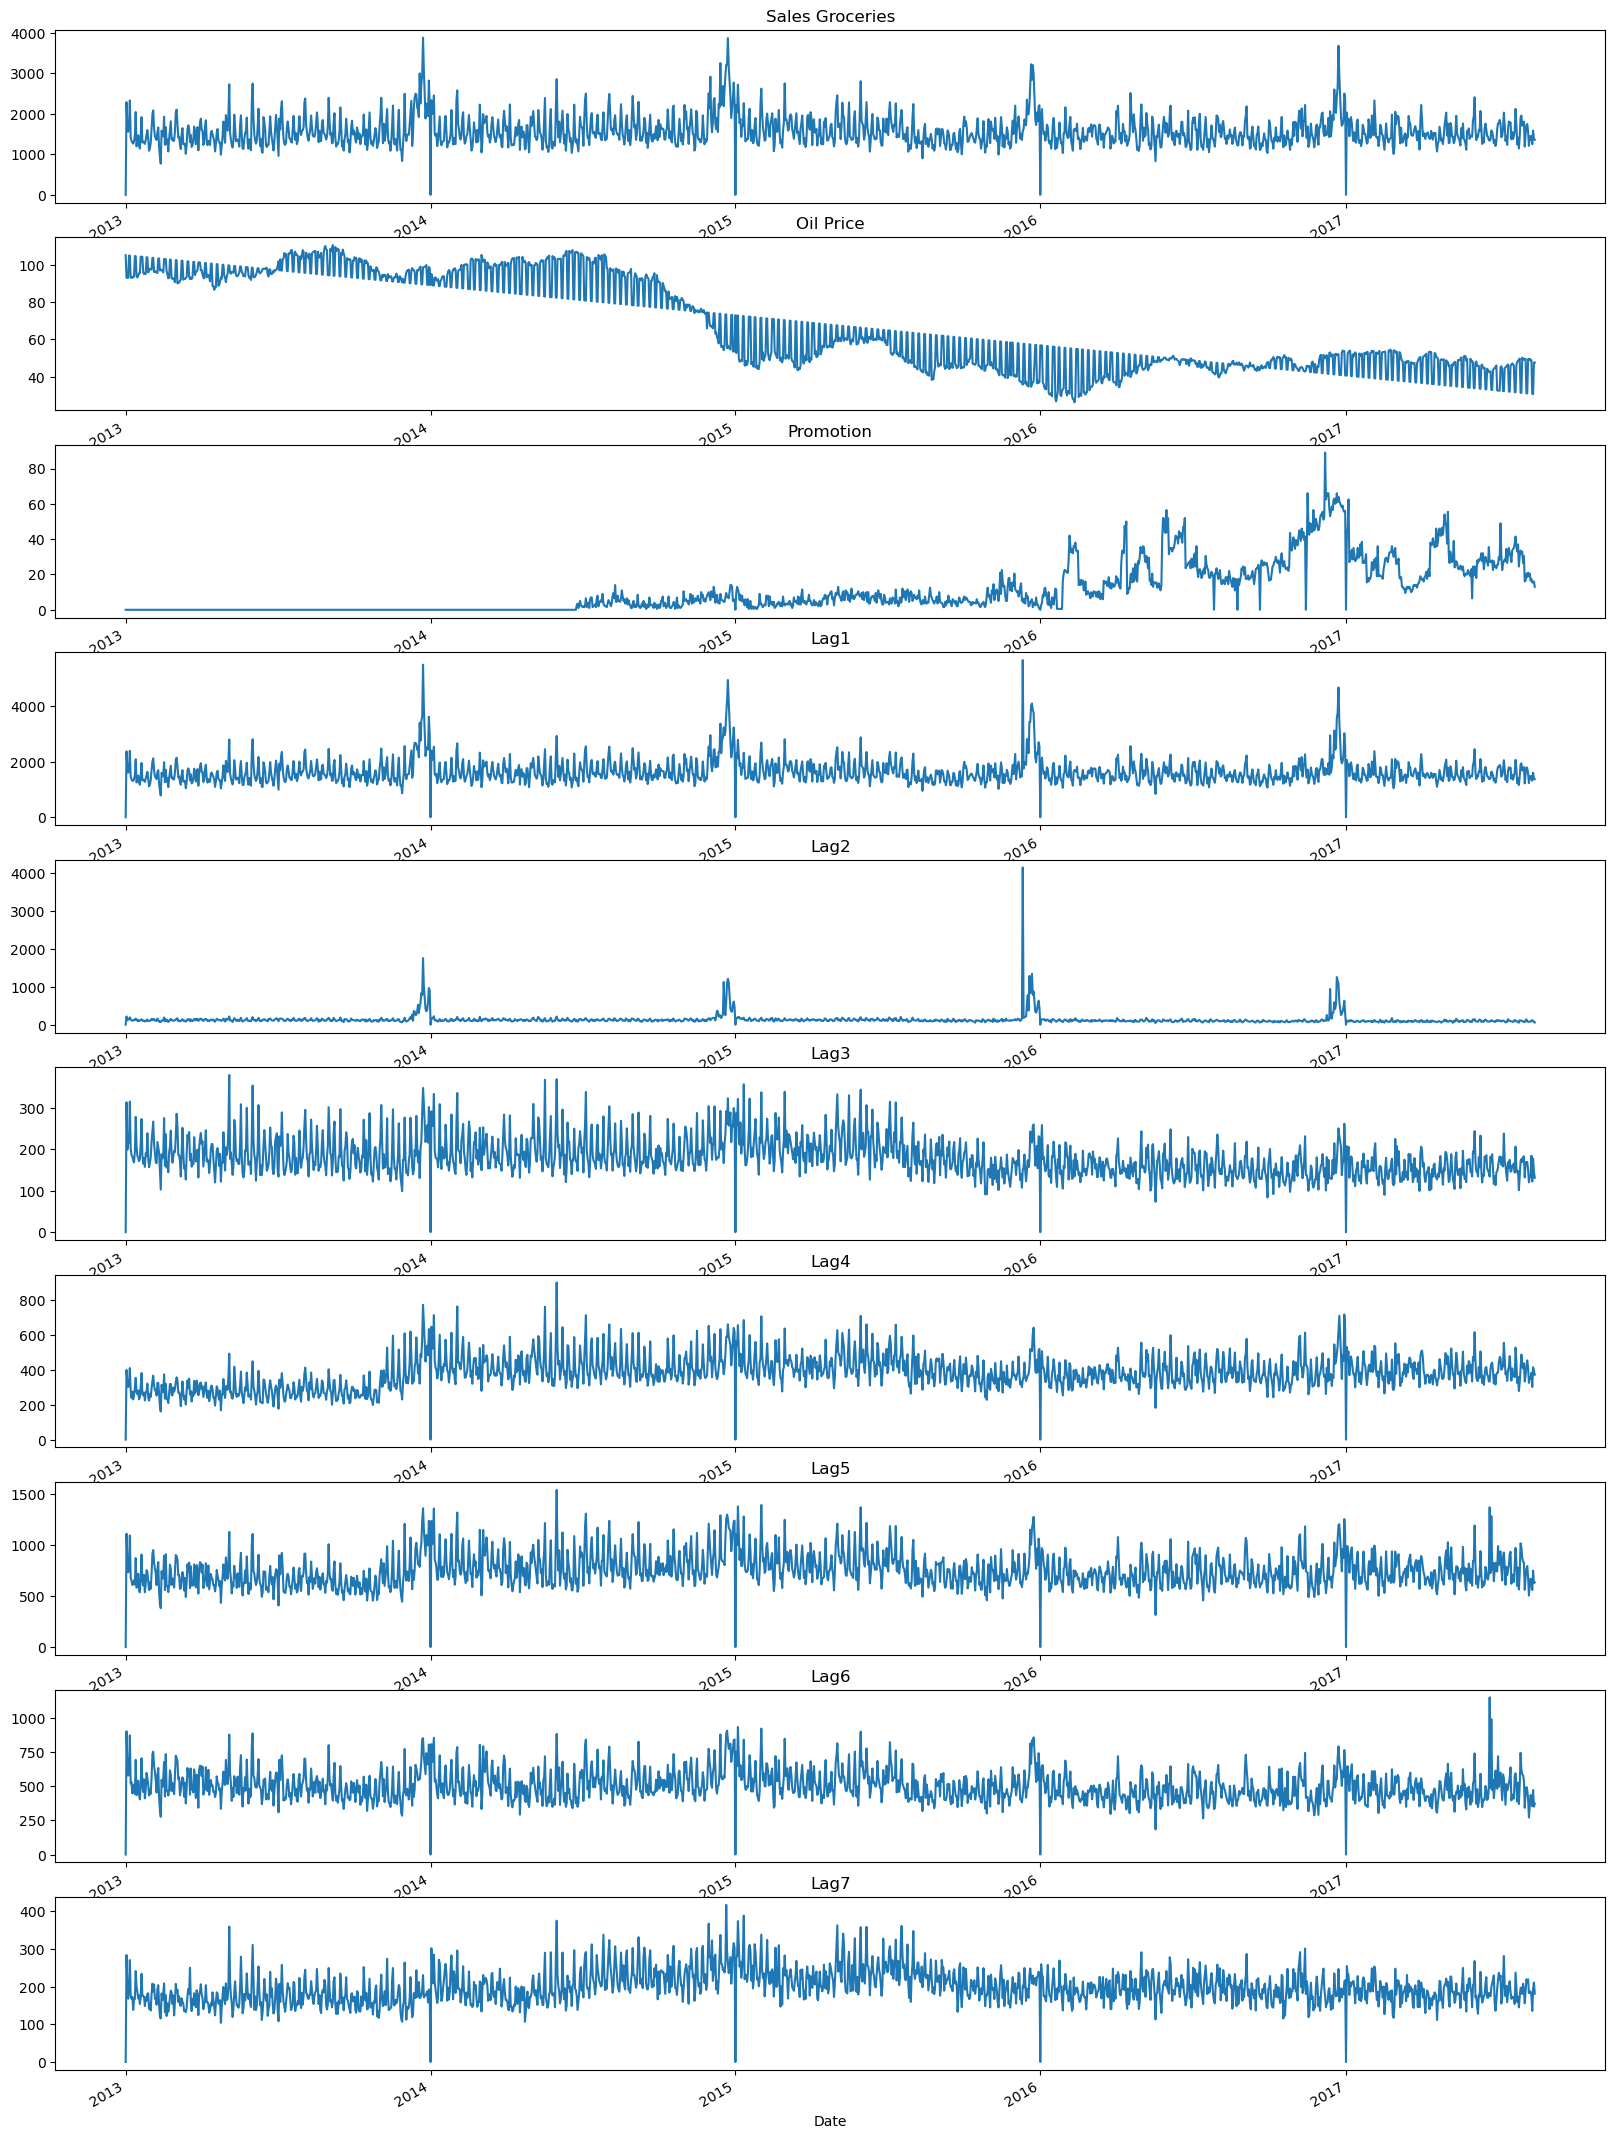

In [177]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9, ax10) = plt.subplots(10, 1, figsize=(20, 30))
df_groceries_try['sales'].plot(ax=ax1, title='Sales Groceries')
df_groceries_try['dcoilwtico'].plot(ax=ax2, title='Oil Price')
df_groceries_try['onpromotion'].plot(ax=ax3, title='Promotion')
df_groceries_try['Lag_1'].plot(ax=ax4, title='Lag1')
df_groceries_try['Lag_2'].plot(ax=ax5, title='Lag2')
df_groceries_try['Lag_3'].plot(ax=ax6, title='Lag3')
df_groceries_try['Lag_4'].plot(ax=ax7, title='Lag4')
df_groceries_try['Lag_5'].plot(ax=ax8, title='Lag5')
df_groceries_try['Lag_6'].plot(ax=ax9, title='Lag6')
df_groceries_try['Lag_7'].plot(ax=ax10, title='Lag7')

# Data Preprocessing

## Checking Missing Values

In [11]:
df_sales.isna().sum()

date               0
family             0
sales              0
onpromotion        0
dcoilwtico     17193
dtype: int64

## Handling Missing Values

No empty values

## Feature Engineering / New Features

In [12]:
df_sales=df_sales.drop(columns=['dcoilwtico'])
df_sales

date                      family     sales  onpromotion
date                                                                    
2013-01-01 2013-01-01                  AUTOMOTIVE     0.000            0
2013-01-01 2013-01-01                   BABY CARE     0.000            0
2013-01-01 2013-01-01                      BEAUTY     0.000            0
2013-01-01 2013-01-01                   BEVERAGES     0.000            0
2013-01-01 2013-01-01                       BOOKS     0.000            0
...               ...                         ...       ...          ...
2017-08-15 2017-08-15                     POULTRY   241.011            1
2017-08-15 2017-08-15              PREPARED FOODS    52.121            0
2017-08-15 2017-08-15                     PRODUCE  1357.823            4
2017-08-15 2017-08-15  SCHOOL AND OFFICE SUPPLIES     0.000            0
2017-08-15 2017-08-15                     SEAFOOD     9.669            0

[55572 rows x 4 columns]

## Correlation

In [13]:
#Moderate to Low Correlation between Sales & Promotion
df_corr=df_sales.select_dtypes(include='number').corr()
df_corr

sales  onpromotion
sales        1.000000     0.448904
onpromotion  0.448904     1.000000

<function matplotlib.pyplot.show(close=None, block=None)>

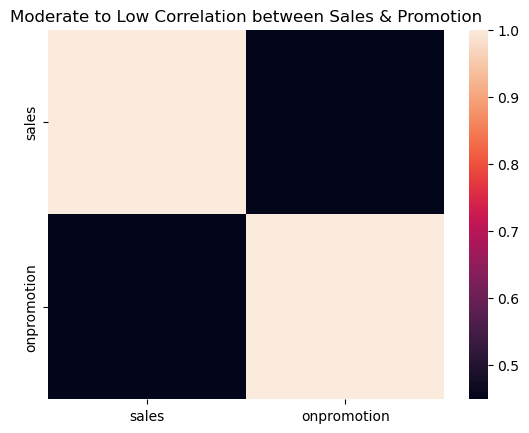

In [14]:
sns.heatmap(df_corr)
plt.title('Moderate to Low Correlation between Sales & Promotion')
plt.show

In [166]:
#Moderate to Low Correlation between Sales & Promotion
df_corr2=df_try.select_dtypes(include='number').corr()

np.fill_diagonal(df_corr2.values, np.nan)  # Replace diagonal with NaN
threshold = 0.5  

pos_corr2 = df_corr2 >= threshold
neg_corr2 = df_corr2 <= -threshold


# Find names of features with high correlation (> 0.5)
pos_corr2_names = df_corr2.columns[(df_corr2 >= threshold).any()]
neg_corr2_names = df_corr2.columns[(df_corr2 <= -threshold).any()]

df_corr2

sales  onpromotion  dcoilwtico     Lag_1     Lag_2     Lag_3  \
sales             NaN     0.448904   -0.043907 -0.071531 -0.040057 -0.081968   
onpromotion  0.448904          NaN   -0.173742 -0.030435 -0.011401 -0.042818   
dcoilwtico  -0.043907    -0.173742         NaN -0.043899 -0.043886 -0.043726   
Lag_1       -0.071531    -0.030435   -0.043899       NaN -0.071534 -0.040045   
Lag_2       -0.040057    -0.011401   -0.043886 -0.071534       NaN -0.071523   
Lag_3       -0.081968    -0.042818   -0.043726 -0.040045 -0.071523       NaN   
Lag_4        0.079588     0.034408   -0.043711 -0.081971 -0.040048 -0.071515   
Lag_5        0.132852     0.054800   -0.043697  0.079588 -0.081972 -0.040047   
Lag_6        0.045169     0.064644   -0.043685  0.132849  0.079585 -0.081962   
Lag_7       -0.065455    -0.038531   -0.043674  0.045166  0.132846  0.079600   

                Lag_4     Lag_5     Lag_6     Lag_7  
sales        0.079588  0.132852  0.045169 -0.065455  
onpromotion  0.034408  0.054800  0.064644 -0.038531  
dcoilwtico  -0.043711 -0.043697 -0.043685 -0.043674  
Lag_1       -0.081971  0.079588  0.132849  0.045166  
Lag_2       -0.040048 -0.081972  0.079585  0.132846  
Lag_3       -0.071515 -0.040047 -0.081962  0.079600  
Lag_4             NaN -0.071515 -0.040050 -0.081964  
Lag_5       -0.071515       NaN -0.071516 -0.040050  
Lag_6       -0.040050 -0.071516       NaN -0.071519  
Lag_7       -0.081964 -0.040050 -0.071519       NaN

In [167]:
print("Features with Positive Correlation ( >= 0.5 ):", pos_corr2_names.tolist())
print("\nFeatures with Negative Correlation ( <= -0.5 ):", neg_corr2_names.tolist())


print("\n\nPositive correlations ( >= 0.5 ):\n", df_corr2[pos_corr2])
print("Negative correlations ( <= -0.5 ):\n", df_corr2[neg_corr2])

Features with Positive Correlation ( >= 0.5 ): []

Features with Negative Correlation ( <= -0.5 ): []


Positive correlations ( >= 0.5 ):
              sales  onpromotion  dcoilwtico  Lag_1  Lag_2  Lag_3  Lag_4  \
sales          NaN          NaN         NaN    NaN    NaN    NaN    NaN   
onpromotion    NaN          NaN         NaN    NaN    NaN    NaN    NaN   
dcoilwtico     NaN          NaN         NaN    NaN    NaN    NaN    NaN   
Lag_1          NaN          NaN         NaN    NaN    NaN    NaN    NaN   
Lag_2          NaN          NaN         NaN    NaN    NaN    NaN    NaN   
Lag_3          NaN          NaN         NaN    NaN    NaN    NaN    NaN   
Lag_4          NaN          NaN         NaN    NaN    NaN    NaN    NaN   
Lag_5          NaN          NaN         NaN    NaN    NaN    NaN    NaN   
Lag_6          NaN          NaN         NaN    NaN    NaN    NaN    NaN   
Lag_7          NaN          NaN         NaN    NaN    NaN    NaN    NaN   

             Lag_5  Lag_6  Lag_7  


<function matplotlib.pyplot.show(close=None, block=None)>

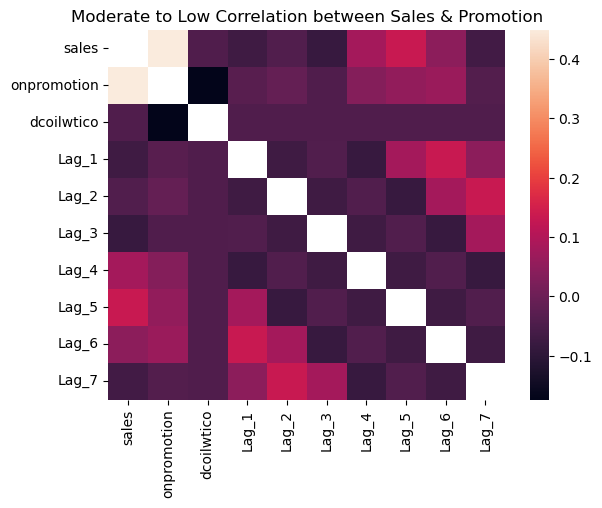

In [ ]:
sns.heatmap(df_corr2)
plt.title('Moderate to Low Correlation between Sales & the other Parameter')
plt.show

In [194]:
#Moderate to Low Correlation between Sales & Promotion
df_corr3=df_groceries_try.select_dtypes(include='number').corr()

np.fill_diagonal(df_corr3.values, np.nan)  # Replace diagonal with NaN

df_corr3 = pd.DataFrame(df_corr3)

threshold3 = 0.5  

sales_corr3 = df_corr3['sales']
sales_corr3

pos_corr3 = sales_corr3 >= threshold
neg_corr3 = sales_corr3 <= -threshold

# Find names of features with high correlation (> 0.5)
pos_corr3_names = sales_corr3.index[pos_corr3].to_list()
neg_corr3_names = sales_corr3.index[neg_corr3].to_list()

# df_corr3

In [197]:
print("Features with Positive Correlation with Sales ( >= 0.5 ):", pos_corr3_names)
print("\nFeatures with Negative Correlation with Sales ( <= -0.5 ):", neg_corr3_names)


print("\n\nPositive correlations with Sales ( >= 0.5 ):\n", sales_corr3.loc[pos_corr3])
print("\nNegative correlations with Sales ( <= -0.5 ):\n", sales_corr3.loc[neg_corr3])

Features with Positive Correlation with Sales ( >= 0.5 ): ['Lag_1', 'Lag_3', 'Lag_4', 'Lag_5', 'Lag_6', 'Lag_7']

Features with Negative Correlation with Sales ( <= -0.5 ): []


Positive correlations with Sales ( >= 0.5 ):
 Lag_1    0.951584
Lag_3    0.753694
Lag_4    0.752522
Lag_5    0.851896
Lag_6    0.820644
Lag_7    0.654077
Name: sales, dtype: float64

Negative correlations with Sales ( <= -0.5 ):
 Series([], Name: sales, dtype: float64)


<function matplotlib.pyplot.show(close=None, block=None)>

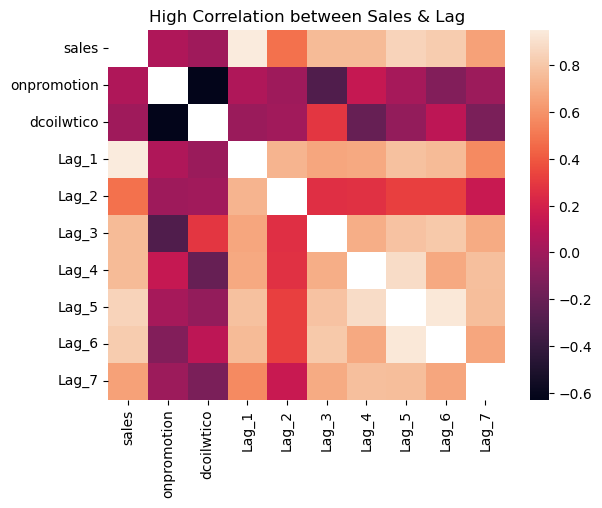

In [199]:
sns.heatmap(df_corr3)
plt.title('High Correlation between Sales & Lag')
plt.show

In [174]:
df_try['Groceries']=np.where((df_try['family'] == 'GROCERY I') | (df_try['family'] == 'GROCERY II'),'Yes','No')
#df_sales['Groceries']=np.where((df_sales['family'] == 'GROCERY I'),'Yes','No')
df_groceries_try=df_try.loc[df_try['Groceries'] == 'Yes']
df_groceries_try=df_groceries_try.rename(columns={'date':'Date'})
df_groceries_try=df_groceries_try.groupby(df_groceries_try['Date']).agg({'sales': 'mean','onpromotion': 'mean','dcoilwtico': 'mean','Lag_1': 'mean','Lag_2': 'mean','Lag_3': 'mean','Lag_4': 'mean','Lag_5': 'mean','Lag_6': 'mean','Lag_7': 'mean'}).rename(columns={'sum':'Sales'}).reset_index()
df_groceries_try.set_index('Date',inplace=True)
df_groceries_try

sales  onpromotion  dcoilwtico      Lag_1     Lag_2     Lag_3  \
Date                                                                         
2013-01-01     0.0          0.0  105.239922     0.0000    0.0000    0.0000   
2013-01-02  2285.5          0.0   93.140000  2372.5840  216.5840  313.7385   
2013-01-03  1634.0          0.0   92.970000  1688.9970  118.9970  199.4120   
2013-01-04  1554.0          0.0   93.120000  1603.0910  131.0910  216.2040   
2013-01-05  1708.0          0.0  105.062879  1780.4550  152.9550  215.8770   
...            ...          ...         ...        ...       ...       ...   
2017-08-11  1451.5         17.5   48.810000  1485.5000  101.0000  184.6815   
2017-08-12  1249.5         15.5   30.704497  1320.1890  120.6890  122.4890   
2017-08-13  1584.0         15.5   30.660236  1604.5000   84.0000  177.4975   
2017-08-14  1367.0         16.0   47.590000  1399.0750   83.0750  145.0815   
2017-08-15  1358.5         13.0   47.570000  1372.7325   58.7325  131.4855   

               Lag_4   Lag_5  Lag_6     Lag_7  
Date                                           
2013-01-01    0.0000     0.0    0.0    0.0000  
2013-01-02  397.7385  1112.0  905.0  283.4585  
2013-01-03  322.4120   835.5  652.5  188.9435  
2013-01-04  300.2040   734.0  579.5  167.8805  
2013-01-05  322.3770   806.5  628.5  201.1430  
...              ...     ...    ...       ...  
2017-08-11  381.6815   632.0  407.0  175.5930  
2017-08-12  300.4890   559.5  354.5  135.4465  
2017-08-13  413.4975   749.5  473.5  193.2125  
2017-08-14  392.5815   628.0  352.0  210.5750  
2017-08-15  370.9855   634.0  374.5  181.2170  

[1684 rows x 10 columns]

## Feature Selection

In [15]:
df_sales['Groceries']=np.where((df_sales['family'] == 'GROCERY I') | (df_sales['family'] == 'GROCERY II'),'Yes','No')
#df_sales['Groceries']=np.where((df_sales['family'] == 'GROCERY I'),'Yes','No')
df_groceries=df_sales.loc[df_sales['Groceries'] == 'Yes']
df_groceries=df_groceries.rename(columns={'date':'Date'})
df_groceries=df_groceries.groupby(df_groceries['Date'])['sales'].agg(['sum']).rename(columns={'sum':'Sales'}).reset_index()
df_groceries.set_index('Date',inplace=True)
df_groceries

Sales
Date              
2013-01-01     0.0
2013-01-02  4571.0
2013-01-03  3268.0
2013-01-04  3108.0
2013-01-05  3416.0
...            ...
2017-08-11  2903.0
2017-08-12  2499.0
2017-08-13  3168.0
2017-08-14  2734.0
2017-08-15  2717.0

[1684 rows x 1 columns]

In [16]:
df_sales_monthly['Groceries']=np.where((df_sales_monthly['family'] == 'GROCERY I') | (df_sales_monthly['family'] == 'GROCERY II'),'Yes','No')
#df_sales['Groceries']=np.where((df_sales['family'] == 'GROCERY I'),'Yes','No')
df_groceries_monthly=df_sales_monthly.loc[df_sales_monthly['Groceries'] == 'Yes']
df_groceries_monthly=df_groceries_monthly.groupby(df_groceries_monthly['Monthly'])['sales'].agg(['sum']).rename(columns={'sum':'Sales'})
df_groceries_monthly

Sales
Monthly               
2013-01-01   87781.000
2013-02-01   81817.000
2013-03-01   90864.000
2013-04-01   84845.000
2013-05-01   93442.000
2013-06-01   92643.000
2013-07-01   96113.000
2013-08-01  100339.000
2013-09-01   90746.000
2013-10-01   89387.000
2013-11-01   90782.000
2013-12-01  130898.000
2014-01-01   93298.000
2014-02-01   88927.000
2014-03-01   99207.000
2014-04-01   88548.000
2014-05-01   96234.000
2014-06-01   93391.000
2014-07-01  100701.000
2014-08-01  105157.000
2014-09-01   93967.000
2014-10-01   96336.000
2014-11-01   97815.000
2014-12-01  143899.000
2015-01-01  101078.000
2015-02-01   92293.000
2015-03-01  104437.000
2015-04-01   92220.000
2015-05-01  106283.000
2015-06-01   94707.000
2015-07-01   99615.000
2015-08-01   86888.000
2015-09-01   80591.000
2015-10-01   91498.000
2015-11-01   88271.000
2015-12-01  120809.760
2016-01-01   89769.898
2016-02-01   85298.000
2016-03-01   92429.000
2016-04-01   94704.000
2016-05-01   94561.000
2016-06-01   89038.000
2016-07-01   93712.000
2016-08-01   91224.000
2016-09-01   83829.000
2016-10-01   88475.000
2016-11-01   96741.000
2016-12-01  118947.000
2017-01-01   92703.000
2017-02-01   83491.000
2017-03-01   97383.000
2017-04-01   89361.000
2017-05-01   92025.000
2017-06-01   91954.000
2017-07-01   99876.000
2017-08-01   44574.000

# Modeling

## Daily

### Stationarity Data

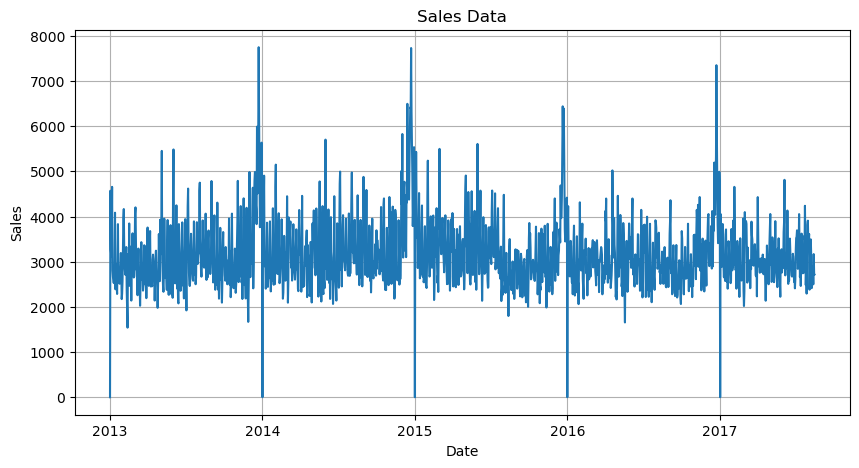

In [17]:
plt.figure(figsize=(10, 5))
plt.plot(df_groceries['Sales'])
plt.title('Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

<Axes: title={'center': 'Residual'}, xlabel='Date'>

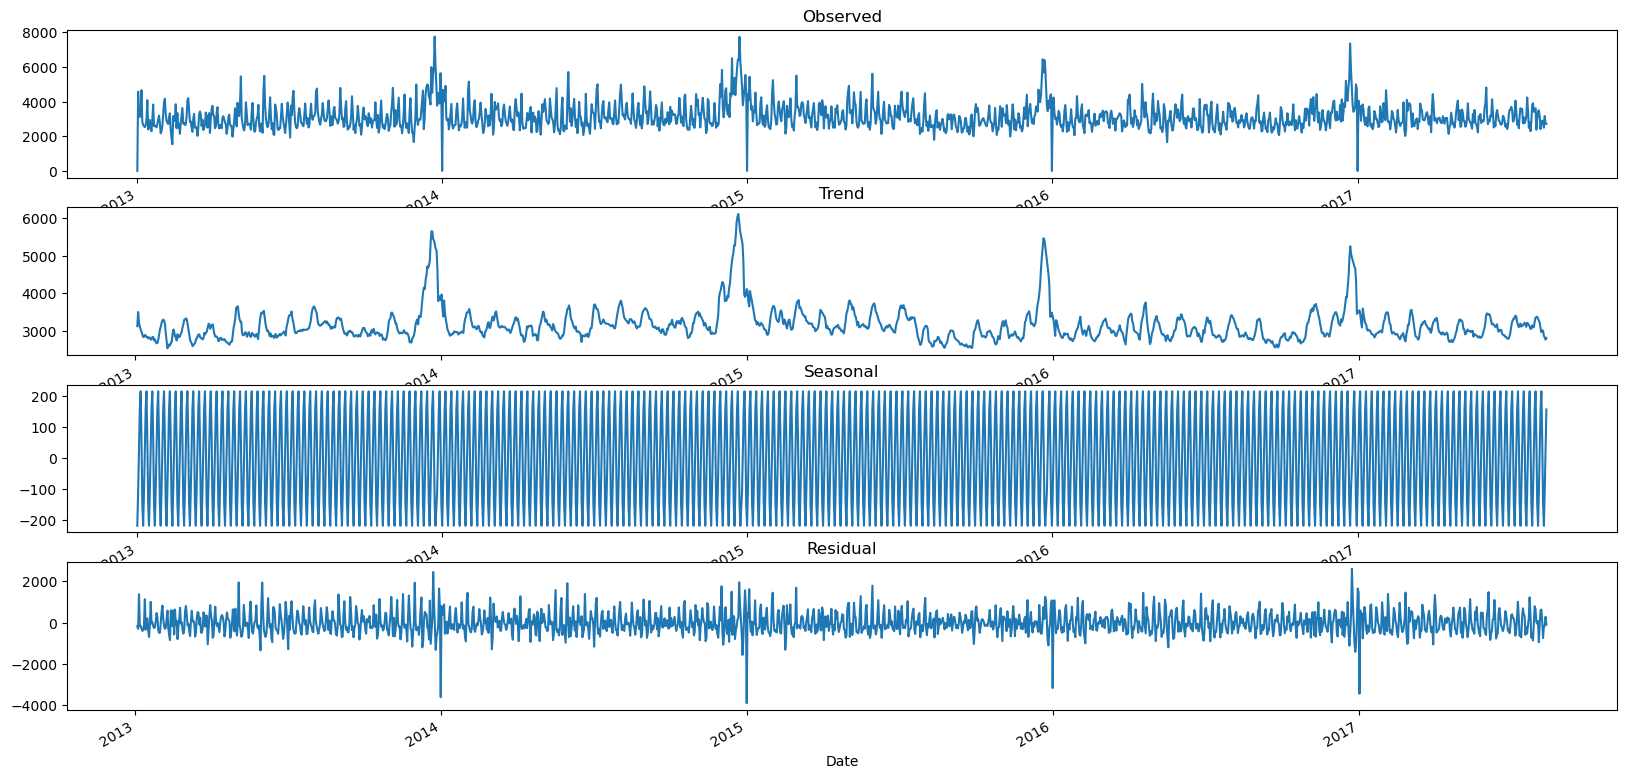

In [18]:
plot_decompose_daily = seasonal_decompose(df_groceries['Sales'], model='additive', period = 7)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10))
plot_decompose_daily.observed.plot(ax=ax1, title='Observed')
plot_decompose_daily.trend.plot(ax=ax2, title='Trend')
plot_decompose_daily.seasonal.plot(ax=ax3, title='Seasonal')
plot_decompose_daily.resid.plot(ax=ax4, title='Residual')

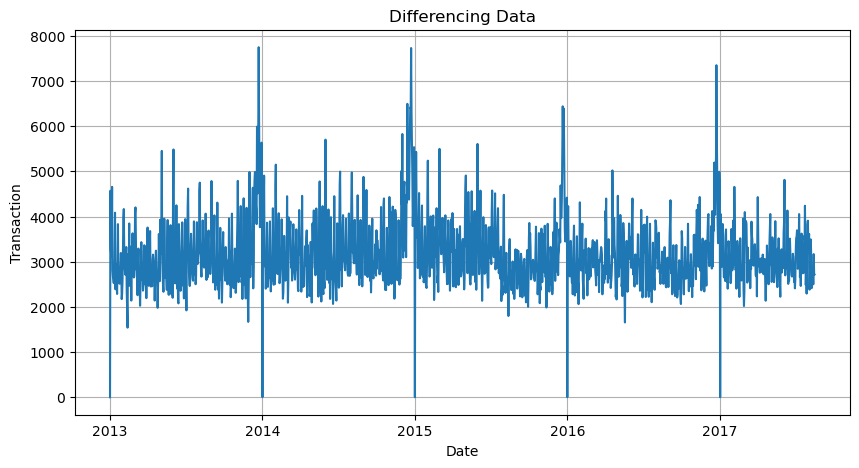

In [19]:
# Plot nilai df_transactions['transactions'].dropna()
plt.figure(figsize=(10, 5))
plt.plot(df_groceries['Sales'].dropna())
plt.title('Differencing Data')
plt.xlabel('Date')
plt.ylabel('Transaction')
plt.grid(True)
plt.show()

In [20]:
result_daily = adfuller(df_groceries['Sales'].dropna())
print('ADF Statistic: %f' % result_daily[0])
print('p-value: %f' % result_daily[1])

ADF Statistic: -7.217694
p-value: 0.000000


Nilai p-value kurang dari 0.05, yang berarti data sudah cukup stasioner

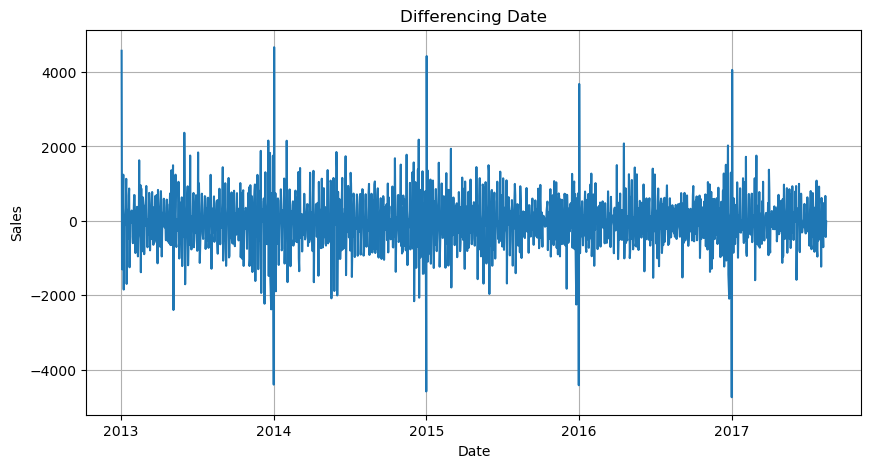

In [21]:
# Plot nilai df_transactions['transactions'].diff().dropna()
plt.figure(figsize=(10, 5))
plt.plot(df_groceries['Sales'].diff().dropna())
plt.title('Differencing Date')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

In [22]:
result_daily = adfuller(df_groceries['Sales'].diff().dropna())
print('ADF Statistic: %f' % result_daily[0])
print('p-value: %f' % result_daily[1])

ADF Statistic: -11.656888
p-value: 0.000000


Nilai p-value kurang dari 0.05, yang berarti data sudah cukup stasioner

### Residual

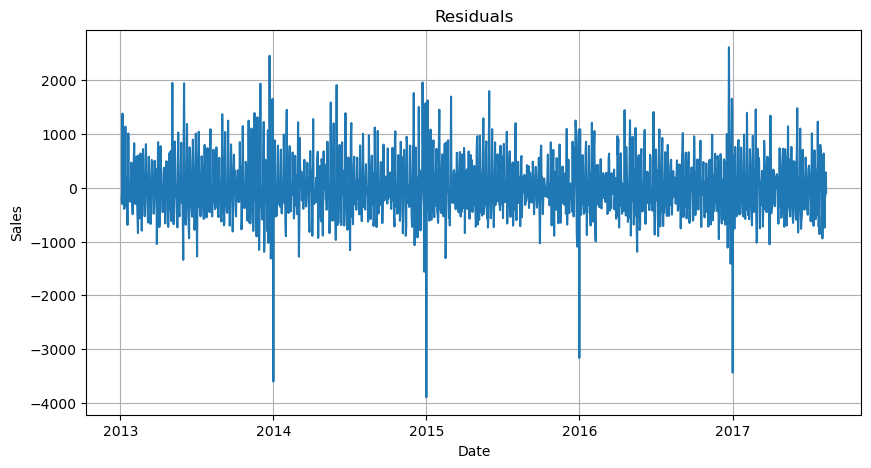

In [23]:
# Residuals diagnostics
residuals_daily = plot_decompose_daily.resid.dropna()
plt.figure(figsize=(10, 5))
plt.plot(residuals_daily)
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

### Train Test Split

In [24]:
len(df_groceries)

1684

In [25]:
# Train 80% Test 20%
train_size = int(0.8 * len(df_groceries))
train_daily = df_groceries['Sales'][:train_size]
test_daily = df_groceries['Sales'][train_size:]


In [26]:
train_daily=pd.DataFrame(train_daily)
train_daily.index = pd.to_datetime(train_daily.index)
train_daily.index = pd.date_range(start=train_daily.index.min(), periods=len(train_daily), freq="D")
print(train_daily,len(train_daily))

             Sales
2013-01-01     0.0
2013-01-02  4571.0
2013-01-03  3268.0
2013-01-04  3108.0
2013-01-05  3416.0
...            ...
2016-09-04  2873.0
2016-09-05  2279.0
2016-09-06  2313.0
2016-09-07  3064.0
2016-09-08  3364.0

[1347 rows x 1 columns] 1347


In [27]:
test_daily=pd.DataFrame(test_daily)
test_daily.index = pd.to_datetime(test_daily.index)
test_daily.index = pd.date_range(start=test_daily.index.min(), periods=len(test_daily), freq="D")
print(test_daily,len(test_daily))

             Sales
2016-09-12  2838.0
2016-09-13  2406.0
2016-09-14  2488.0
2016-09-15  2239.0
2016-09-16  2922.0
...            ...
2017-08-10  2903.0
2017-08-11  2499.0
2017-08-12  3168.0
2017-08-13  2734.0
2017-08-14  2717.0

[337 rows x 1 columns] 337


### Train Clean Up Data

In [28]:
# Sales Data Only
train_desc_daily=pd.DataFrame(train_daily.describe())

IQR = train_desc_daily.loc['75%','Sales'] - train_desc_daily.loc['25%','Sales']
train_upper_daily = train_desc_daily.loc['75%','Sales'] + 1.5*IQR

if train_desc_daily.loc['25%','Sales'] - 1.5*IQR <0:
    train_lower_daily = 0
else:
    train_lower_daily = train_desc_daily.loc['25%','Sales'] - 1.5*IQR

print(
    train_desc_daily,
    '\n\nIQR = ', IQR,
    '\nUpper Limit = ', train_upper_daily,
    '\nLower Limit = ', train_lower_daily
)

             Sales
count  1347.000000
mean   3155.729516
std     760.118322
min       0.000000
25%    2659.500000
50%    3005.000000
75%    3509.500000
max    7747.000000 

IQR =  850.0 
Upper Limit =  4784.5 
Lower Limit =  1384.5


### Data Cleaning

<Axes: >

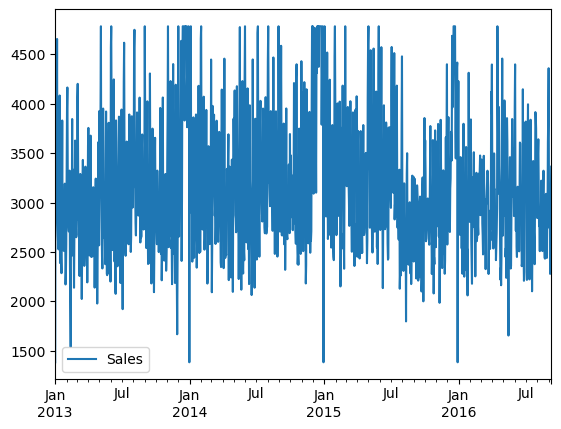

In [29]:
train_clean_daily = pd.DataFrame(train_daily)
train_clean_daily['Sales'] = np.where(train_clean_daily['Sales'] > train_upper_daily,train_upper_daily,train_clean_daily['Sales'])
train_clean_daily['Sales'] = np.where(train_clean_daily['Sales'] < train_lower_daily,train_lower_daily,train_clean_daily['Sales'])
train_clean_daily.index = pd.to_datetime(train_clean_daily.index)
train_clean_daily.index = pd.date_range(start=train_clean_daily.index.min(), periods=len(train_clean_daily), freq="D")
train_clean_daily.plot()

### ACF and PACF Plot

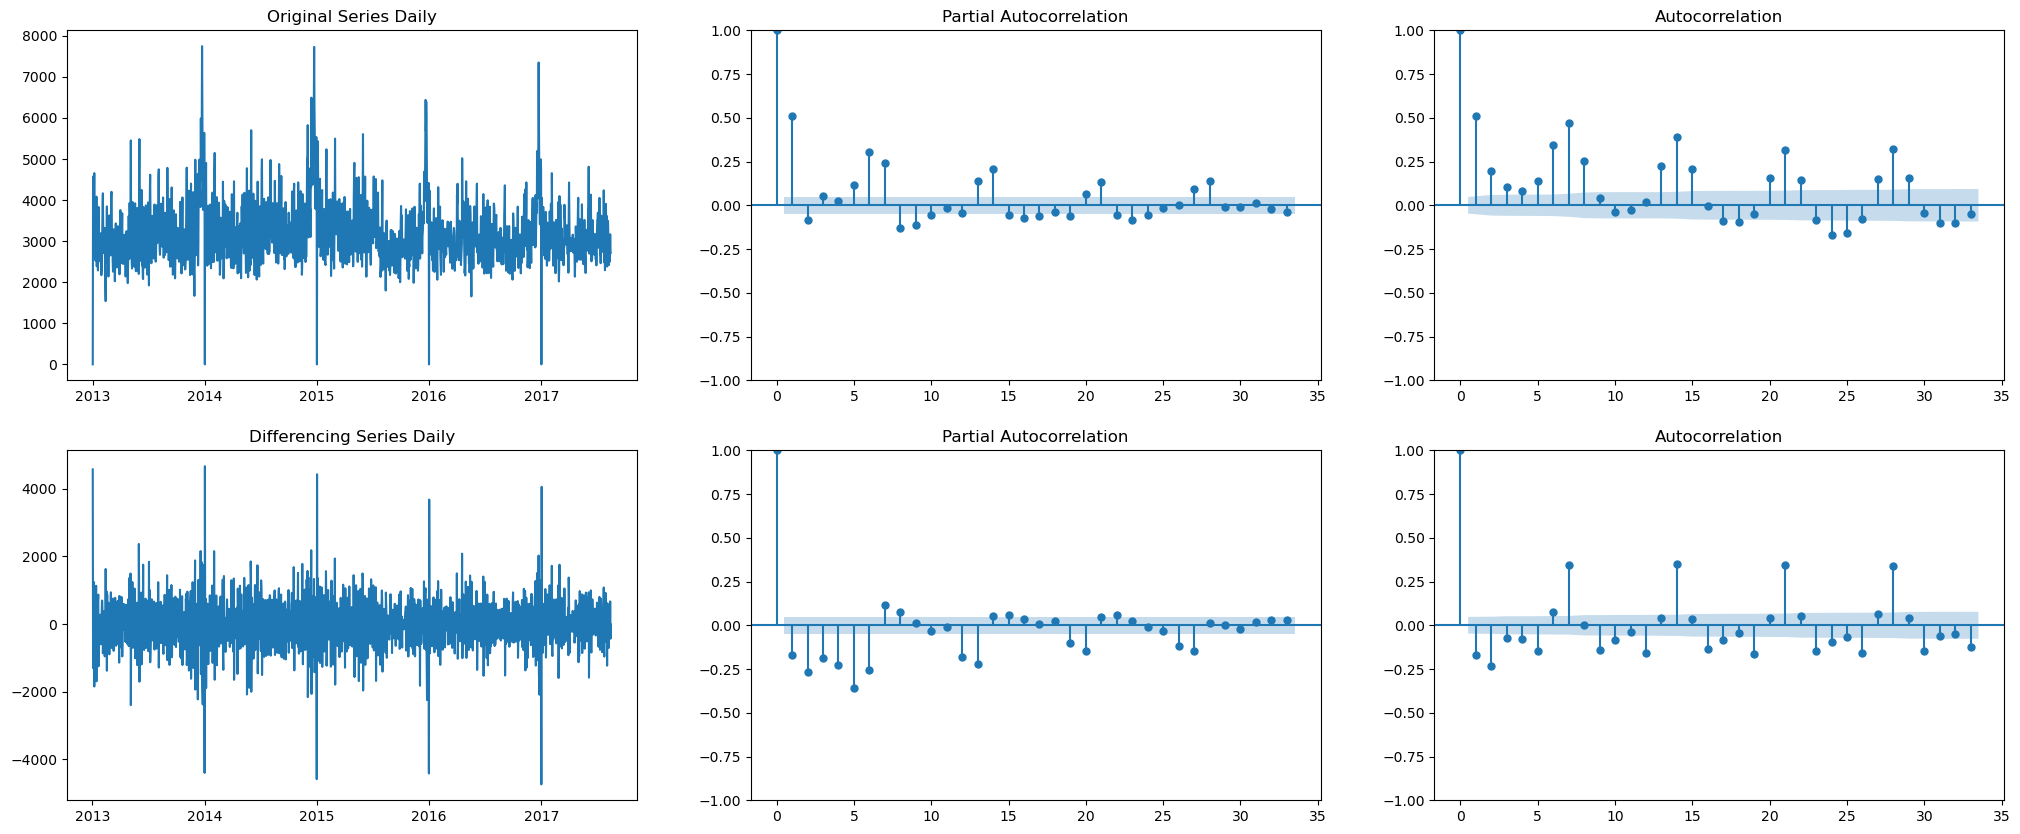

In [112]:
# Plot ACF dan PACF
fig, ax = plt.subplots(2, 3, figsize=(25, 10))

ax[0, 0].set_title('Original Series Daily')
ax[0, 0].plot(df_groceries['Sales'])
ax[0, 1] = plot_pacf(df_groceries['Sales'], ax=ax[0, 1])
ax[0, 2] = plot_acf(df_groceries['Sales'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series Daily')
ax[1, 0].plot(df_groceries['Sales'].diff().dropna())
ax[1, 1] = plot_pacf(df_groceries['Sales'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_acf(df_groceries['Sales'].diff().dropna(), ax=ax[1, 2])



plt.show()

### Define Order (p, d, q)

Dari PACF, kita bisa mengambilkan nilai AR(p) = 1,<br>
Dari ACF, kita bisa mengambilkan nilai MA(q) = 1,<br>
Dari hasil uji diagnostik, kita bisa mengambilkan nilai d = 0, <br>
Dari PACF, kita bisa mengambil kesimpulan seasonal = 7  
Dari data decompose 'Trend', kita bisa mengambil kesimpulan seasonal = 365  

### ARIMA 365

In [31]:
# ARIMA Model
arima_daily_365 = ARIMA(train_clean_daily, order=(1,0,1), seasonal_order=(1,0,1,365))
model_fit_arima_daily_365 = arima_daily_365.fit()
print(model_fit_arima_daily_365.summary())

c:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


                                     SARIMAX Results                                     
Dep. Variable:                             Sales   No. Observations:                 1347
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 365)   Log Likelihood              -10430.306
Date:                           Mon, 02 Jun 2025   AIC                          20872.611
Time:                                   18:42:13   BIC                          20903.845
Sample:                               01-01-2013   HQIC                         20884.309
                                    - 09-08-2016                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3133.8059     28.804    108.799      0.000    3077.352    3190.260
ar.L1          0.3509      0.041      8.466

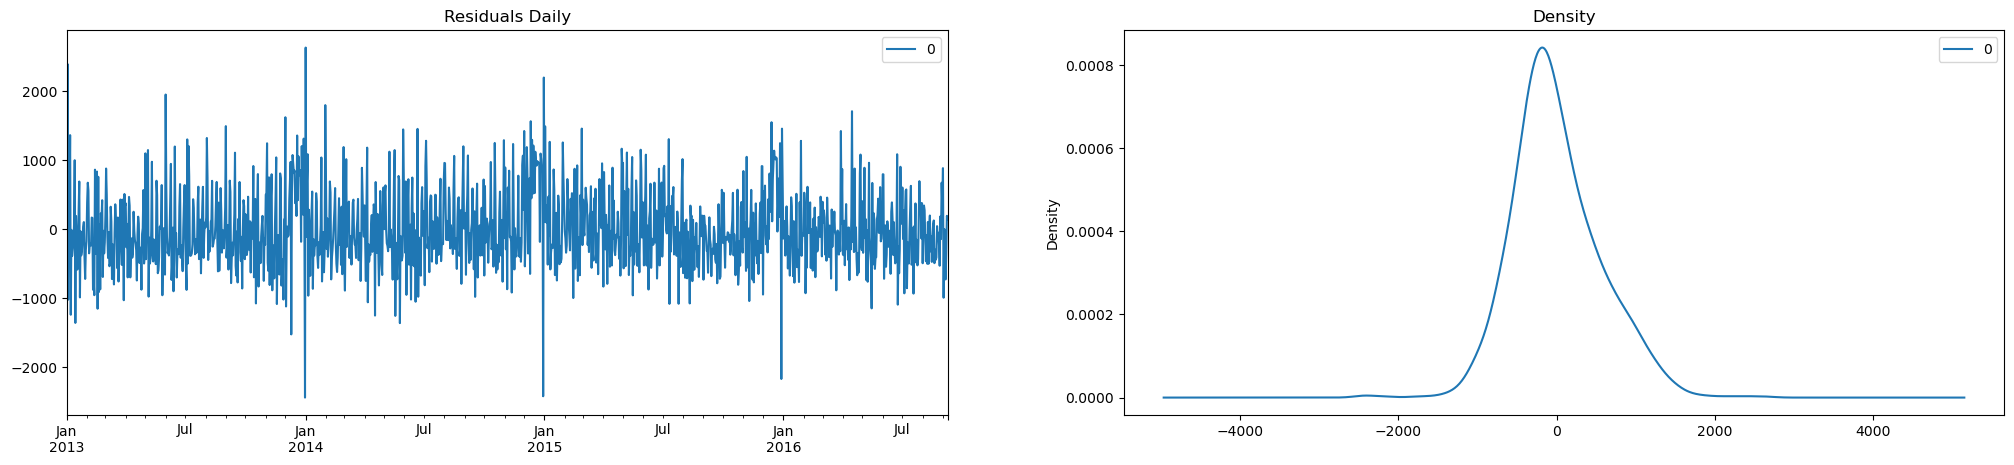

In [111]:
# Plot residual errors
residuals_arima_daily_365 = pd.DataFrame(model_fit_arima_daily_365.resid)
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals_arima_daily_365.plot(title="Residuals Daily", ax=ax[0])
residuals_arima_daily_365.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

c:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


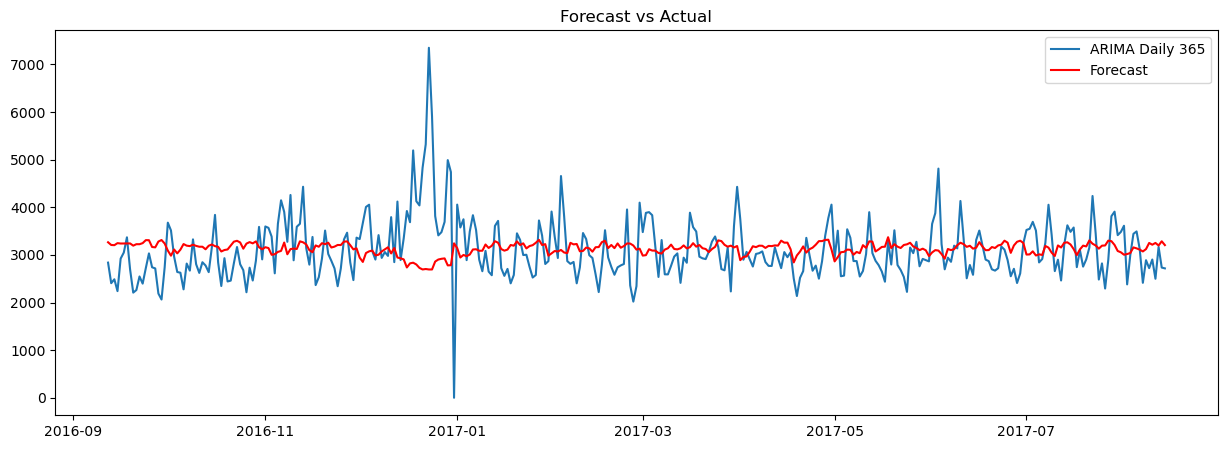

In [232]:
# Prediction
predict_arima_daily_365 = model_fit_arima_daily_365.predict(start=len(train_daily), end=len(df_groceries)-1, typ='levels')
predict_arima_daily_365.index = test_daily.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test_daily, label='ARIMA Daily 365')
plt.plot(predict_arima_daily_365, label='Forecast', color='r')
plt.legend()

### ARIMA 7

In [34]:
# ARIMA Model
arima_daily_7 = ARIMA(train_clean_daily, order=(1,0,1), seasonal_order=(1,0,1,7))
model_fit_arima_daily_7 = arima_daily_7.fit()
print(model_fit_arima_daily_7.summary())

                                    SARIMAX Results                                    
Dep. Variable:                           Sales   No. Observations:                 1347
Model:             ARIMA(1, 0, 1)x(1, 0, 1, 7)   Log Likelihood              -10155.832
Date:                         Mon, 02 Jun 2025   AIC                          20323.664
Time:                                 18:42:16   BIC                          20354.897
Sample:                             01-01-2013   HQIC                         20335.362
                                  - 09-08-2016                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       3133.7039    169.536     18.484      0.000    2801.419    3465.989
ar.L1          0.7240      0.031     23.250      0.000     

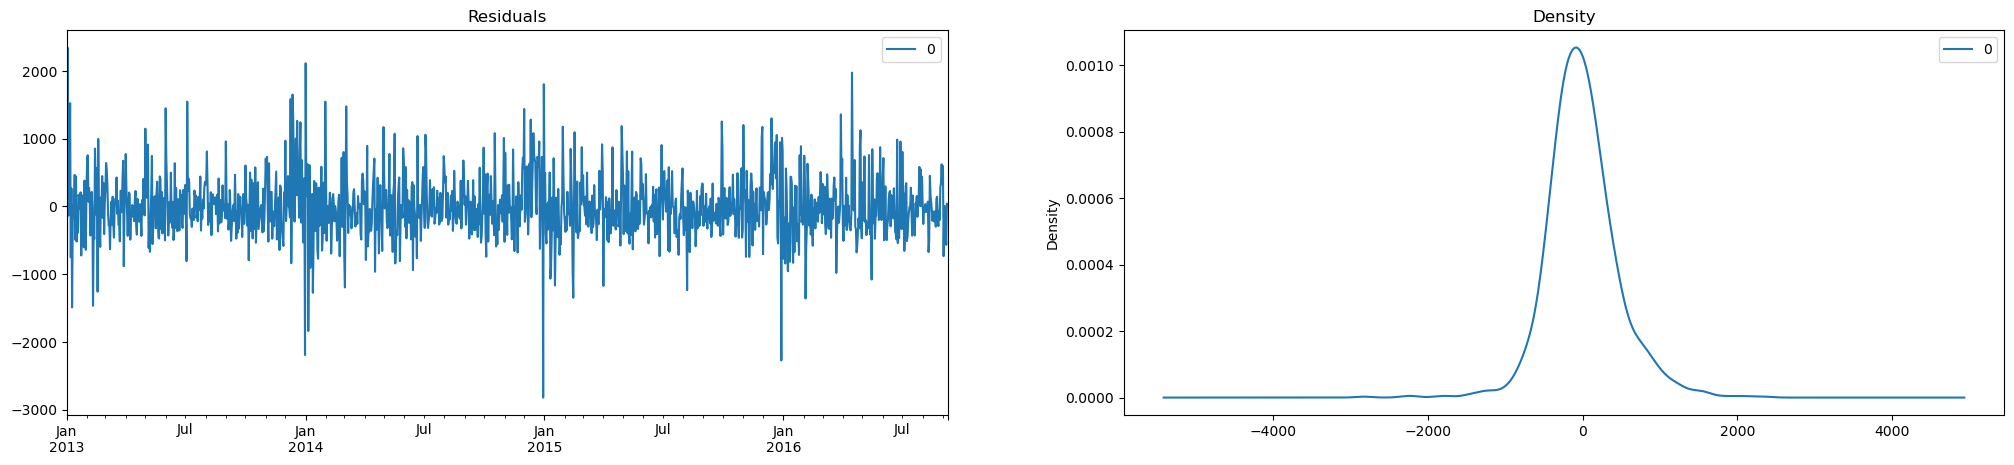

In [35]:
# Plot residual errors
residuals_arima_daily_7 = pd.DataFrame(model_fit_arima_daily_7.resid)
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals_arima_daily_7.plot(title="Residuals", ax=ax[0])
residuals_arima_daily_7.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

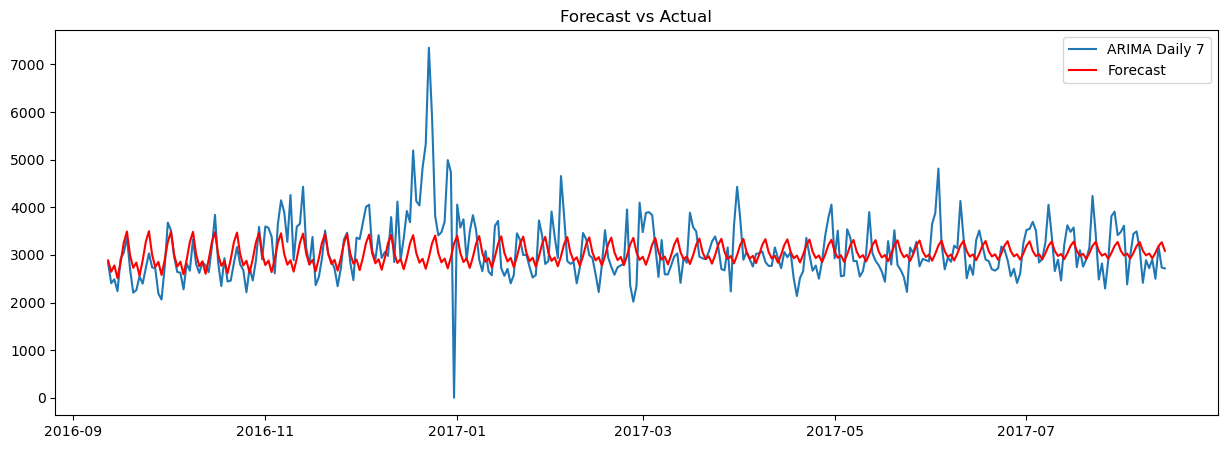

In [233]:
# Prediction
predict_arima_daily_7 = model_fit_arima_daily_7.predict(start=len(train_daily), end=len(df_groceries)-1, typ='levels')
predict_arima_daily_7.index = test_daily.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test_daily, label='ARIMA Daily 7')
plt.plot(predict_arima_daily_7, label='Forecast', color='r')
plt.legend()

### Auto Arima

In [37]:
auto_arima_daily = pm.auto_arima(train_clean_daily,
                      start_p=1,        # nilai p pertama
                      start_q=1,        # nilai q pertama
                      test='adf',       # gunakan adftest untuk mencari optimal 'd'
                      max_p=12,          # maksimal p
                      max_q=12,          # maksimal q
                      d=0,           # let model determine 'd'
                      m=7,             # frequency of series
                      seasonal=True,    # Seasonality
                      start_P=1,        # nilai P pertama
                      D=0,           # let model determine 'D'
                      start_Q=1,        # nilai Q pertama
                      max_P=3,          # maksimal P
                      max_D=0,          # maksimal D
                      max_Q=3,          # maksimal Q
                      trace=True,       # print result
                      error_action='ignore',    # we don't want to know if an order does not work
                      suppress_warnings=True,   # we don't want convergence warnings
                      stepwise=True)        # set to stepwise

print(auto_arima_daily.summary())

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(1,0,1)[7] intercept   : AIC=20642.860, Time=2.56 sec
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=21315.579, Time=0.02 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=20587.562, Time=2.17 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=20739.386, Time=0.54 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=25569.740, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[7] intercept   : AIC=20930.449, Time=0.05 sec
 ARIMA(1,0,0)(2,0,0)[7] intercept   : AIC=20550.169, Time=8.12 sec
 ARIMA(1,0,0)(3,0,0)[7] intercept   : AIC=20687.710, Time=34.01 sec
 ARIMA(1,0,0)(2,0,1)[7] intercept   : AIC=20532.894, Time=2.76 sec
 ARIMA(1,0,0)(1,0,1)[7] intercept   : AIC=inf, Time=1.35 sec
 ARIMA(1,0,0)(3,0,1)[7] intercept   : AIC=inf, Time=nan sec
 ARIMA(1,0,0)(2,0,2)[7] intercept   : AIC=inf, Time=3.23 sec
 ARIMA(1,0,0)(1,0,2)[7] intercept   : AIC=20587.982, Time=2.53 sec
 ARIMA(1,0,0)(3,0,2)[7] intercept   : AIC=20596.640, Time=8.12 sec
 ARIMA(0,0,0)(2,0,1)[7] intercept   :

In [38]:
predict_auto_arima_daily = auto_arima_daily.predict(n_periods=10000)
predict_auto_arima_daily = predict_auto_arima_daily.reindex(test_daily.index)
predict_auto_arima_daily

2016-09-12    2464.806915
2016-09-13    2831.045636
2016-09-14    3288.655089
2016-09-15    3537.933192
2016-09-16    2991.168992
                 ...     
2017-08-10    3436.197910
2017-08-11    2897.522662
2017-08-12    2601.622235
2017-08-13    2711.383765
2017-08-14    2402.178971
Freq: D, Length: 337, dtype: float64

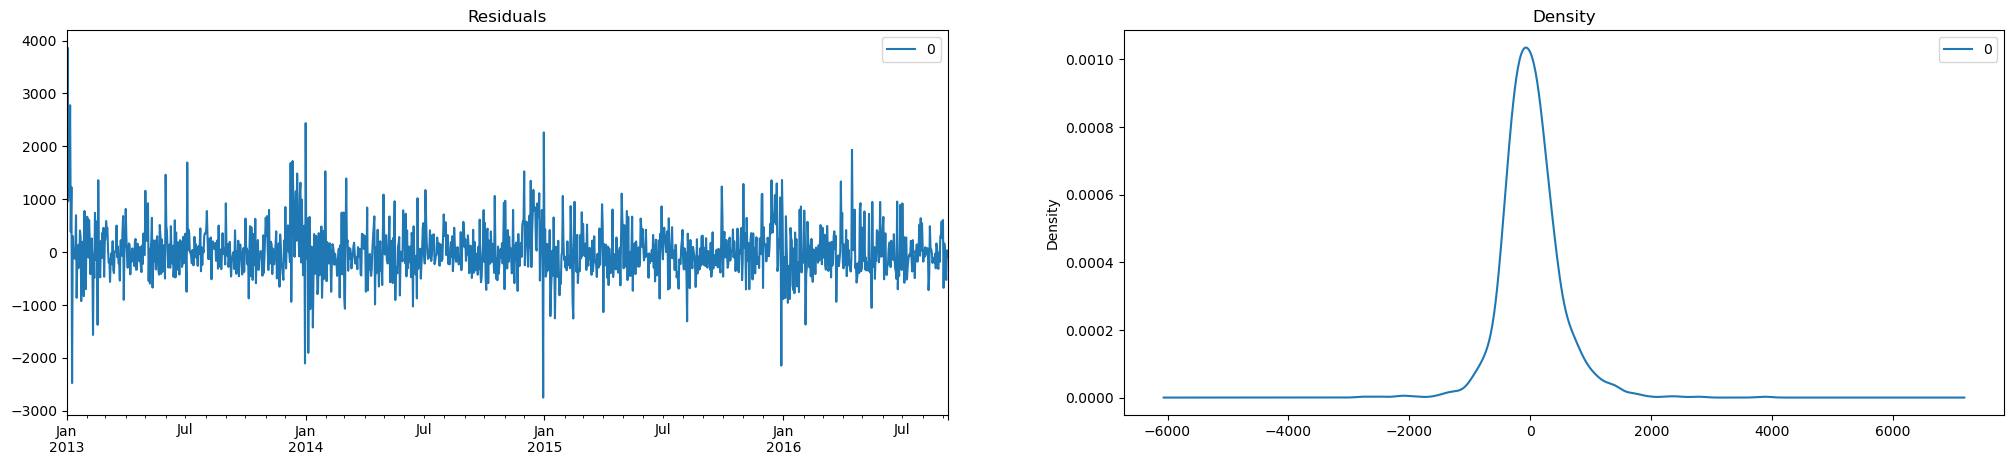

In [39]:
residuals_auto_arima_daily = pd.DataFrame(auto_arima_daily.resid())
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals_auto_arima_daily.plot(title="Residuals", ax=ax[0])
residuals_auto_arima_daily.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

Text(0, 0.5, 'Jumlah Transaksi')

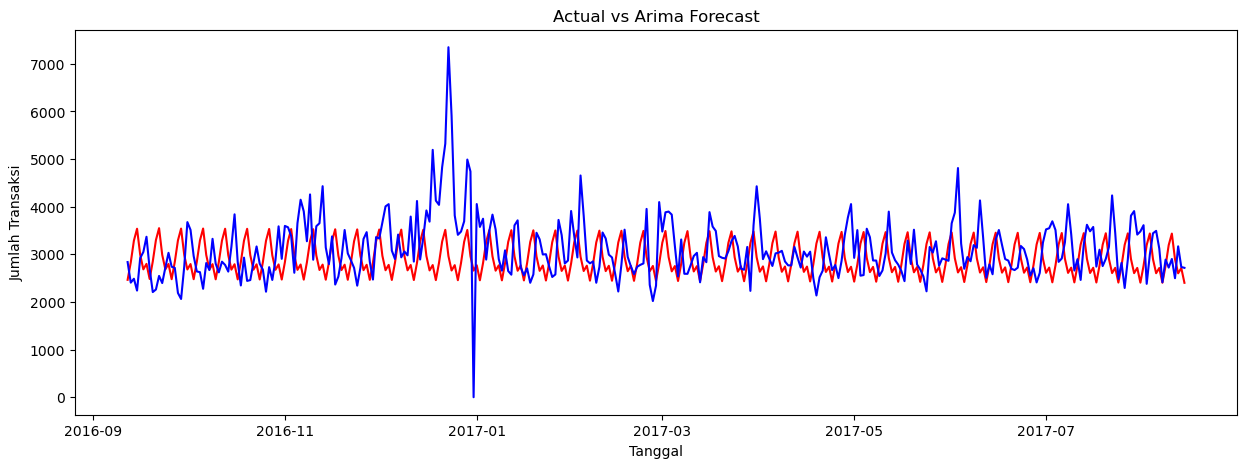

In [40]:
plt.figure(figsize=(15,5))
plt.plot(predict_auto_arima_daily, color='red', label='Auto Arima Daily')
plt.plot(test_daily, color='blue')
plt.title('Actual vs Arima Forecast')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Transaksi')

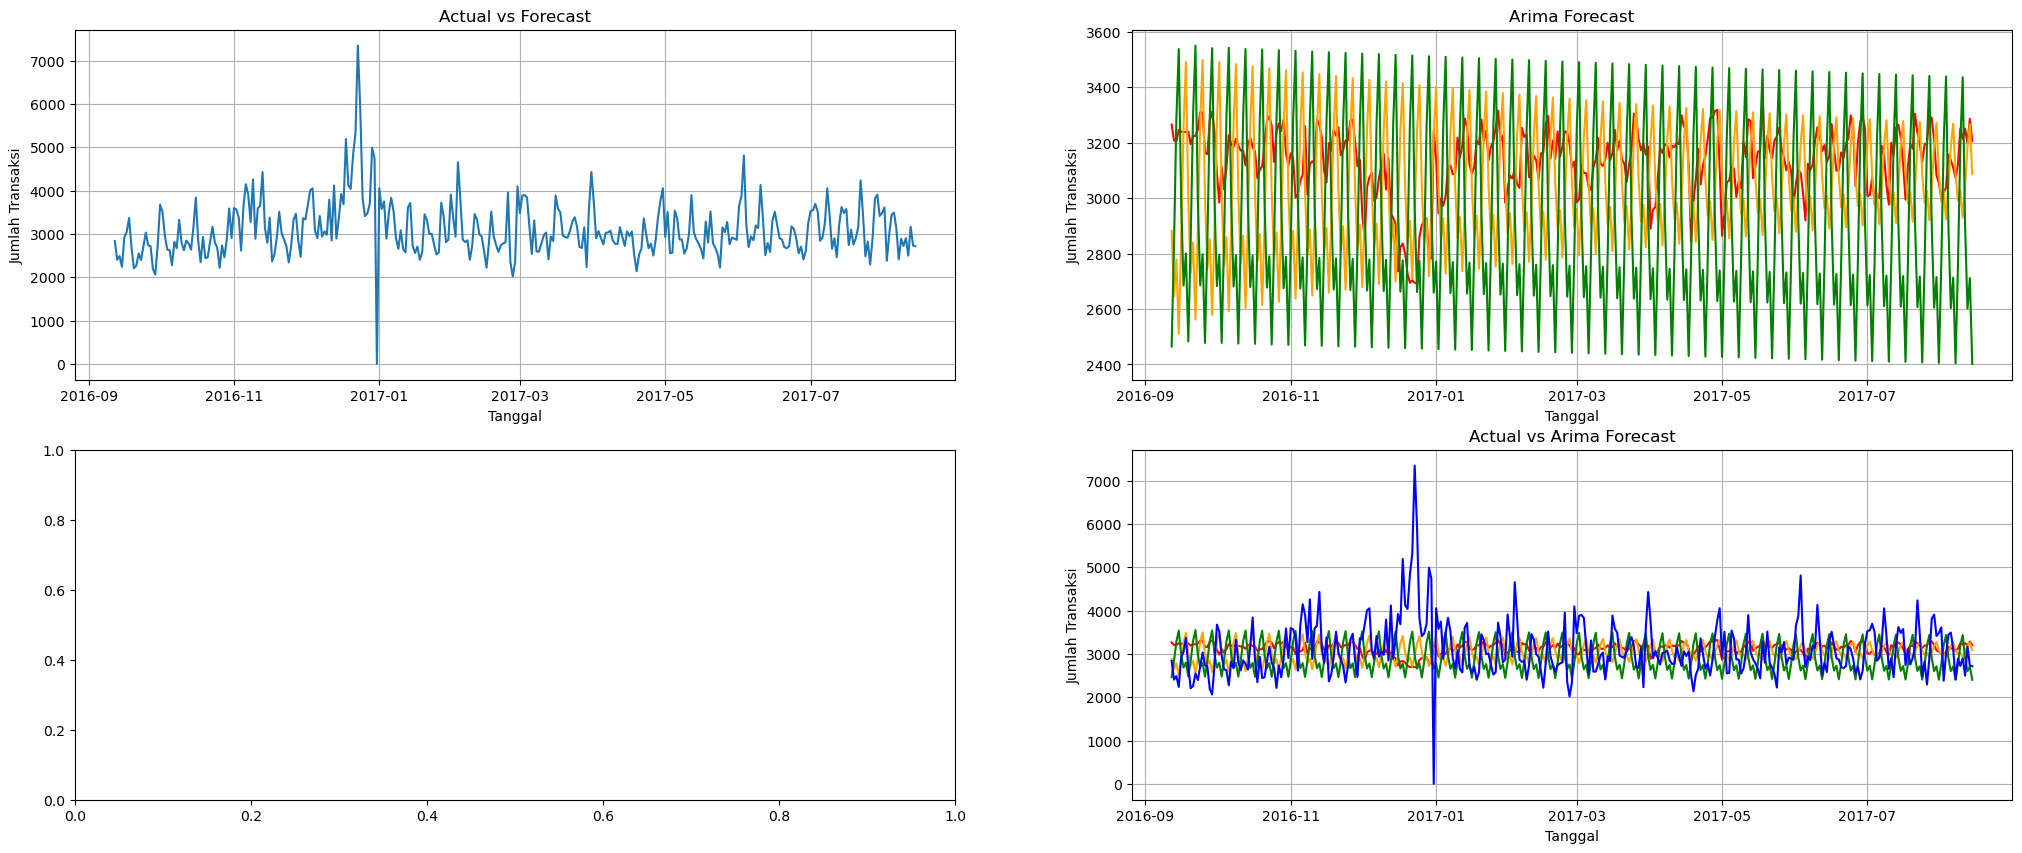

In [202]:
# Predict data
start_index = 0
end_index = len(df_groceries)+100

# Forecast using previous forecast function

# Actual
actual = test_daily

# Plot actual vs forecast
fig, ax = plt.subplots(2, 2, figsize=(25, 10))
ax[0,0].plot(actual)
ax[0,0].set_title('Actual vs Forecast')
ax[0,0].set_xlabel('Tanggal')
ax[0,0].set_ylabel('Jumlah Transaksi')
ax[0,0].grid(True)

ax[0,1].plot(predict_arima_daily_365, color='red', label='Arima Daily 365')
ax[0,1].plot(predict_arima_daily_7, color='orange', label='Arima Daily 7')
ax[0,1].plot(predict_auto_arima_daily, color='green', label='Auto Arima Daily')
ax[0,1].set_title('Arima Forecast')
ax[0,1].set_xlabel('Tanggal')
ax[0,1].set_ylabel('Jumlah Transaksi')
ax[0,1].grid(True)


ax[1,1].plot(predict_arima_daily_365, color='red', label='Arima Daily 365')
ax[1,1].plot(predict_arima_daily_7, color='orange', label='Arima Daily 7')
ax[1,1].plot(predict_auto_arima_daily, color='green', label='Auto Arima Daily')
ax[1,1].plot(actual, color='blue')
ax[1,1].set_title('Actual vs Arima Forecast')
ax[1,1].set_xlabel('Tanggal')
ax[1,1].set_ylabel('Jumlah Transaksi')
ax[1,1].grid(True)

### LSTM

#### Scaller

In [42]:
scaler_daily = MinMaxScaler()
train_daily.head(), test_daily.head()

(             Sales
 2013-01-01     0.0
 2013-01-02  4571.0
 2013-01-03  3268.0
 2013-01-04  3108.0
 2013-01-05  3416.0,
              Sales
 2016-09-12  2838.0
 2016-09-13  2406.0
 2016-09-14  2488.0
 2016-09-15  2239.0
 2016-09-16  2922.0)

#### LSTM Training

In [43]:
trainLSTM_daily = train_daily.values.reshape(-1, 1)
testLSTM_daily = test_daily.values.reshape(-1, 1)
series_testLSTM_daily = test_daily.values.reshape(-1)
series_testLSTM_daily = pd.Series(series_testLSTM_daily)
series_testLSTM_daily.index = test_daily.index

scaler_daily.fit(trainLSTM_daily)
# reshape the data
scaled_train_daily = scaler_daily.transform(trainLSTM_daily)
scaled_test_daily = scaler_daily.transform(testLSTM_daily)
scaled_all_daily = scaler_daily.transform(actual)

c:\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [44]:
series_testLSTM_daily

2016-09-12    2838.0
2016-09-13    2406.0
2016-09-14    2488.0
2016-09-15    2239.0
2016-09-16    2922.0
               ...  
2017-08-10    2903.0
2017-08-11    2499.0
2017-08-12    3168.0
2017-08-13    2734.0
2017-08-14    2717.0
Freq: D, Length: 337, dtype: float64

In [45]:
scaled_train_daily[:10]

array([[0.        ],
       [0.59003485],
       [0.42184071],
       [0.40118756],
       [0.44094488],
       [0.60100684],
       [0.36259197],
       [0.34374597],
       [0.33251581],
       [0.32619078]])

In [46]:
# Fine Tuning Parameter

n_input_daily = 10
n_features_daily = 1
batch_size_daily = 1
epoch_size_daily = [10, 50, 100, 200, 300]

In [47]:
generator_daily = TimeseriesGenerator(scaled_train_daily, scaled_train_daily, length=n_input_daily, batch_size=batch_size_daily)
val_generator_daily = TimeseriesGenerator(scaled_test_daily, scaled_test_daily, length=n_input_daily, batch_size=batch_size_daily)


# define model
model_LSTM_daily = Sequential()
model_LSTM_daily.add(LSTM(50, input_shape=(n_input_daily, n_features_daily)))
model_LSTM_daily.add(Dense(1))
model_LSTM_daily.compile(optimizer='adam', loss='mse')

model_LSTM_daily.summary()

C:\Users\Ryan Mahendradani\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
# fit model
early_stopping_daily = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# model_LSTM_daily.fit(generator_daily, epochs=epoch_size_daily, validation_data=val_generator_daily, callbacks=[early_stopping_daily])

for epoch_size_daily in epoch_size_daily:
    history_daily = model_LSTM_daily.fit(generator_daily, epochs=epoch_size_daily, validation_data=val_generator_daily)
    print(f"Epoch {epoch_size_daily} - Final Validation Loss: {history_daily.history['val_loss'][-1]}")



Epoch 1/10


C:\Users\Ryan Mahendradani\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1337/1337 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0132 - val_loss: 0.0058
Epoch 2/10
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0077 - val_loss: 0.0054
Epoch 3/10
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0073 - val_loss: 0.0053
Epoch 4/10
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0069 - val_loss: 0.0107
Epoch 5/10
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0061 - val_loss: 0.0100
Epoch 6/10
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0063 - val_loss: 0.0050
Epoch 7/10
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0047 - val_loss: 0.0049
Epoch 8/10
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step - loss: 0.0064 - val_loss: 0.0046
Epoch 9/10
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0055 - val_loss: 0.0050
Epoch 10/10
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0071 - val_loss: 0.0046
Epoch 10 - Final Validation Loss: 0.004569198004901409
Epoch 1/50
1337/1337 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0052 - val_

In [49]:
trainpredict_daily = model_LSTM_daily.predict(scaled_train_daily)
testpredict_daily = model_LSTM_daily.predict(scaled_test_daily)

# Reshape trainPredict and testPredict for plotting
trainpredict_daily = trainpredict_daily.reshape(-1, 1)
testpredict_daily = testpredict_daily.reshape(-1, 1)

trainpredict_daily = scaler_daily.inverse_transform(trainpredict_daily)
trainactual_daily = scaler_daily.inverse_transform(scaled_train_daily)
testpredict_daily = scaler_daily.inverse_transform(testpredict_daily)
testactual_daily = scaler_daily.inverse_transform(scaled_test_daily)

predict_LSTM_daily = testpredict_daily.copy()
predict_LSTM_daily = predict_LSTM_daily.reshape(-1,1)
actual_LSTM_daily = testactual_daily.copy()
actual_LSTM_daily = actual_LSTM_daily.reshape(-1, 1)
print(predict_LSTM_daily.shape)
print(actual_LSTM_daily.shape)

43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
(337, 1)
(337, 1)


#### Predictions

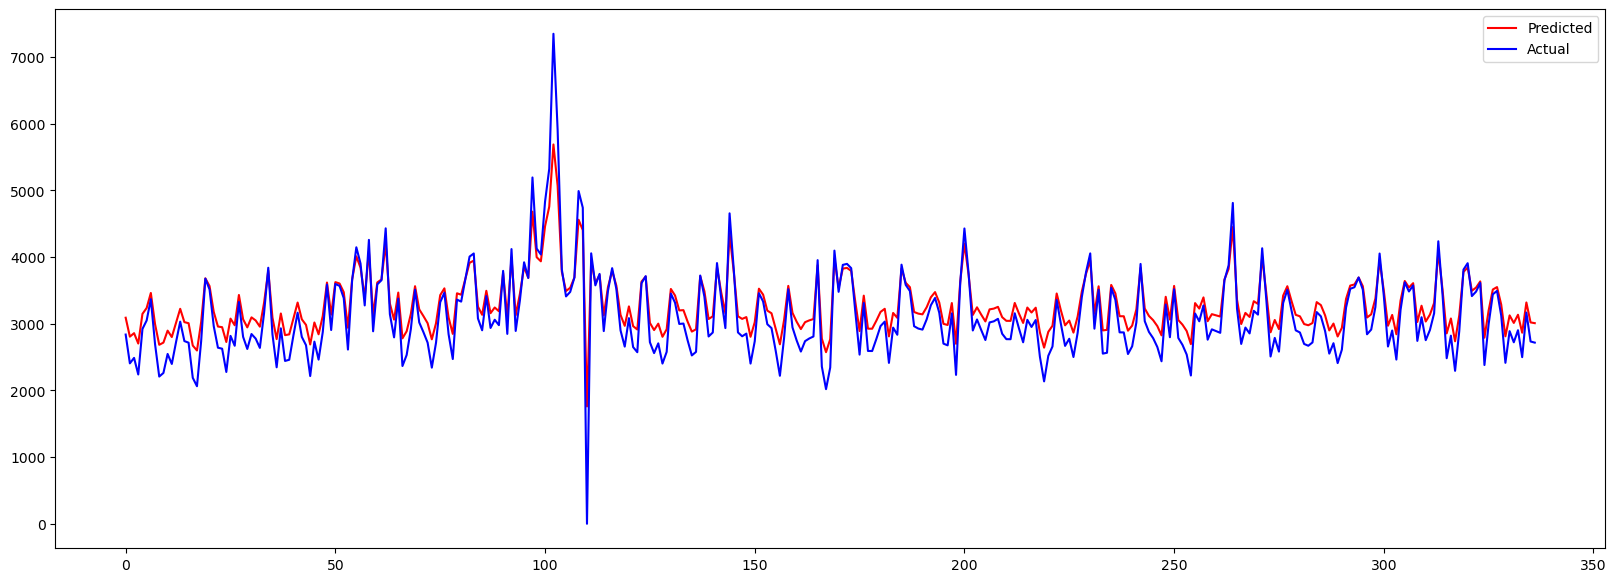

In [ ]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(predict_LSTM_daily), label='LSTM Daily', color = 'Red')
plt.plot(pd.DataFrame(actual_LSTM_daily), label='Actual', color = 'blue')
plt.legend(loc='best')
plt.show()

## Monthly

### Stationarity Data

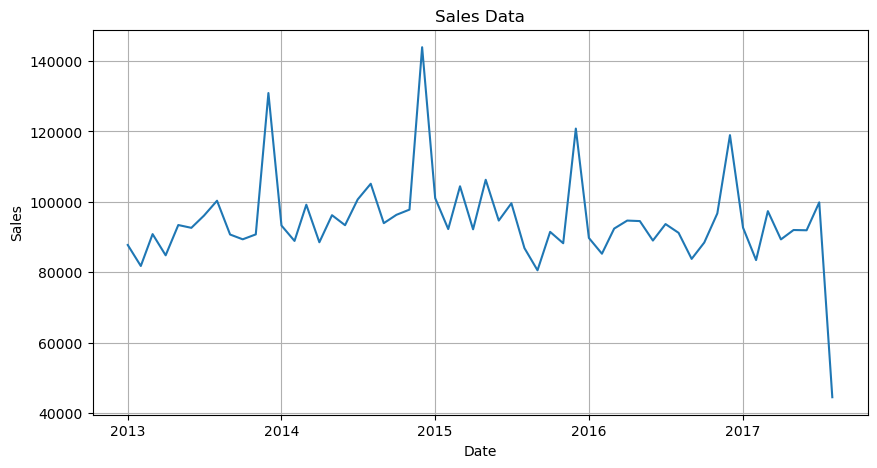

In [51]:
plt.figure(figsize=(10, 5))
plt.plot(df_groceries_monthly['Sales'])
plt.title('Sales Data')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

<Axes: title={'center': 'Residual'}, xlabel='Monthly'>

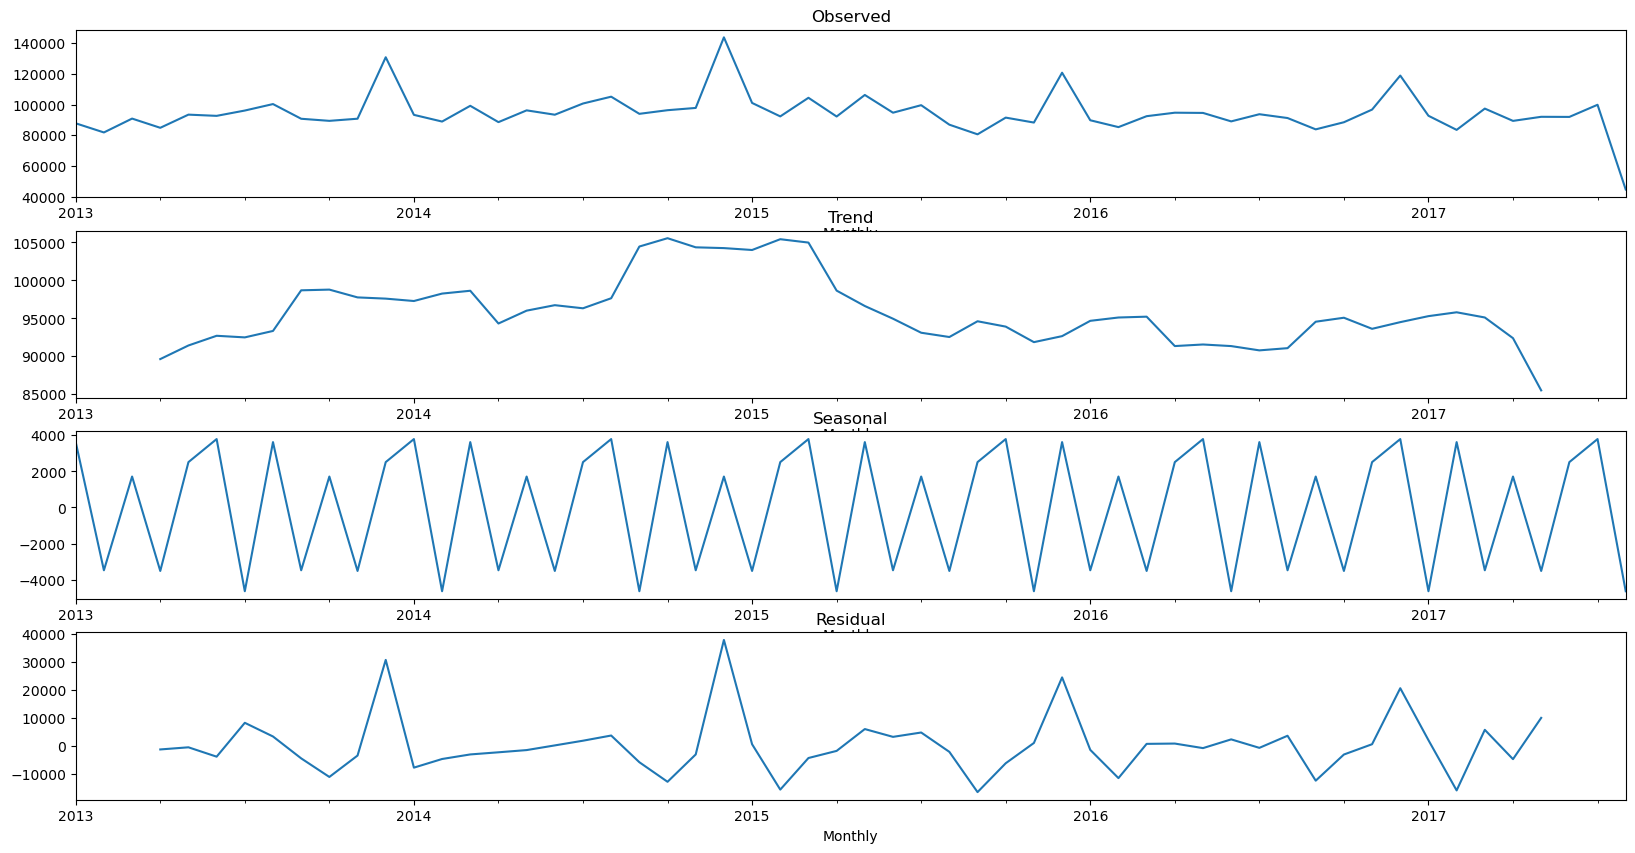

In [52]:
plot_decompose_monthly = seasonal_decompose(df_groceries_monthly['Sales'], model='additive', period = 7)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10))
plot_decompose_monthly.observed.plot(ax=ax1, title='Observed')
plot_decompose_monthly.trend.plot(ax=ax2, title='Trend')
plot_decompose_monthly.seasonal.plot(ax=ax3, title='Seasonal')
plot_decompose_monthly.resid.plot(ax=ax4, title='Residual')

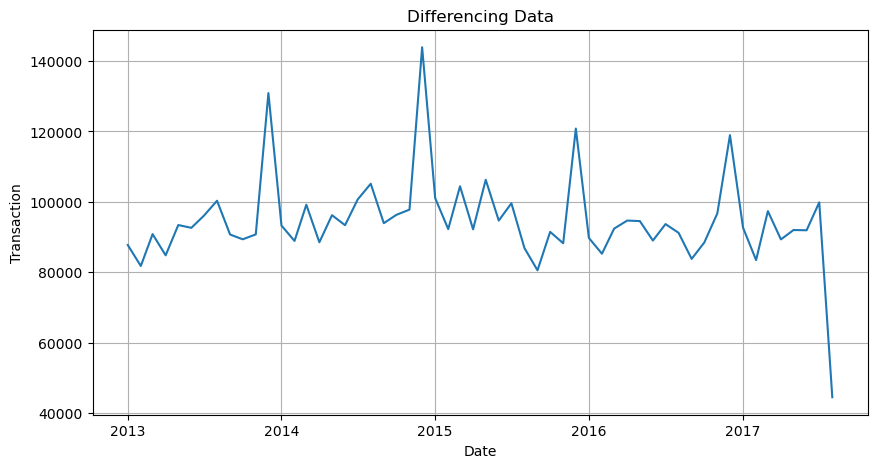

In [53]:
# Plot nilai df_transactions['transactions'].dropna()
plt.figure(figsize=(10, 5))
plt.plot(df_groceries_monthly['Sales'].dropna())
plt.title('Differencing Data')
plt.xlabel('Date')
plt.ylabel('Transaction')
plt.grid(True)
plt.show()

In [54]:
result_monthly = adfuller(df_groceries_monthly['Sales'].dropna())
print('ADF Statistic: %f' % result_monthly[0])
print('p-value: %f' % result_monthly[1])

ADF Statistic: 0.281954
p-value: 0.976501


Nilai p-value lebih dari 0.05, yang berarti data belum stasioner

<Axes: title={'center': 'Residual'}, xlabel='Monthly'>

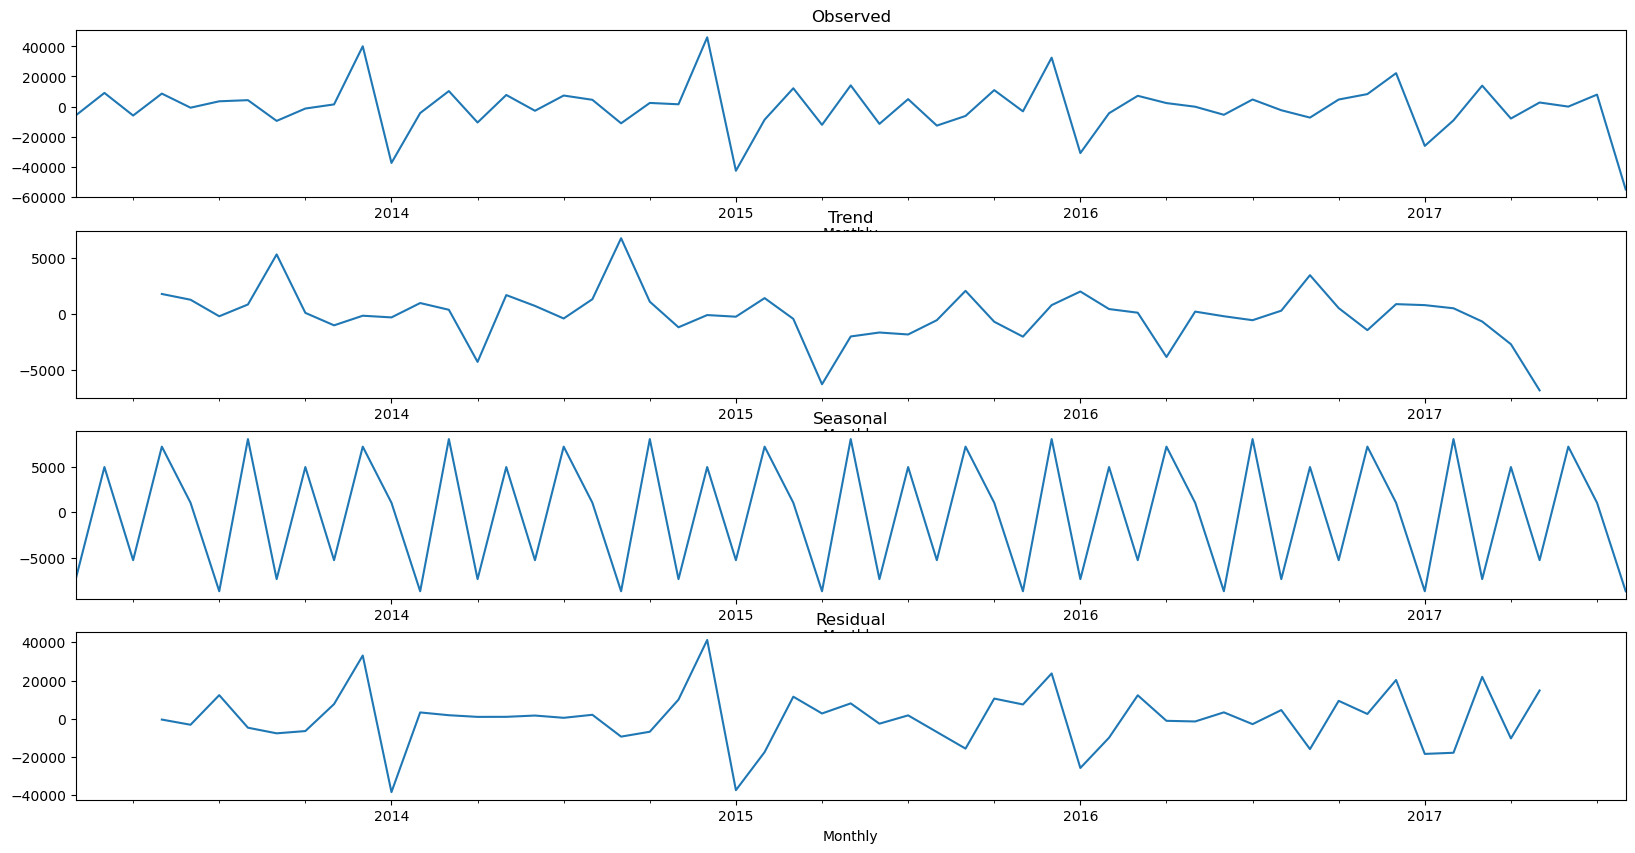

In [55]:
plot_decompose_monthly_diff = seasonal_decompose(df_groceries_monthly['Sales'].diff().dropna(), model='additive', period = 7)
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(20, 10))
plot_decompose_monthly_diff.observed.plot(ax=ax1, title='Observed')
plot_decompose_monthly_diff.trend.plot(ax=ax2, title='Trend')
plot_decompose_monthly_diff.seasonal.plot(ax=ax3, title='Seasonal')
plot_decompose_monthly_diff.resid.plot(ax=ax4, title='Residual')

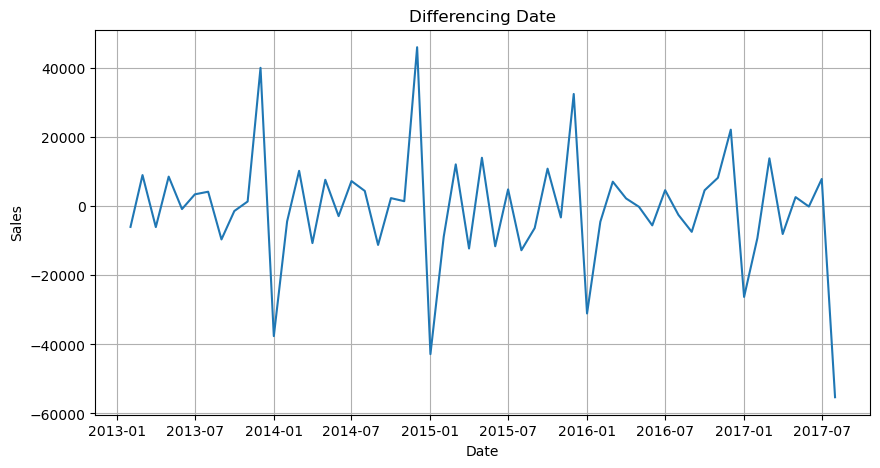

In [56]:
# Plot nilai df_transactions['transactions'].diff().dropna()
plt.figure(figsize=(10, 5))
plt.plot(df_groceries_monthly['Sales'].diff().dropna())
plt.title('Differencing Date')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

In [57]:
result_monthly = adfuller(df_groceries_monthly['Sales'].diff().dropna())
print('ADF Statistic: %f' % result_monthly[0])
print('p-value: %f' % result_monthly[1])

ADF Statistic: -5.097529
p-value: 0.000014


Nilai p-value kurang dari 0.05, yang berarti data sudah cukup stasioner

### Residual

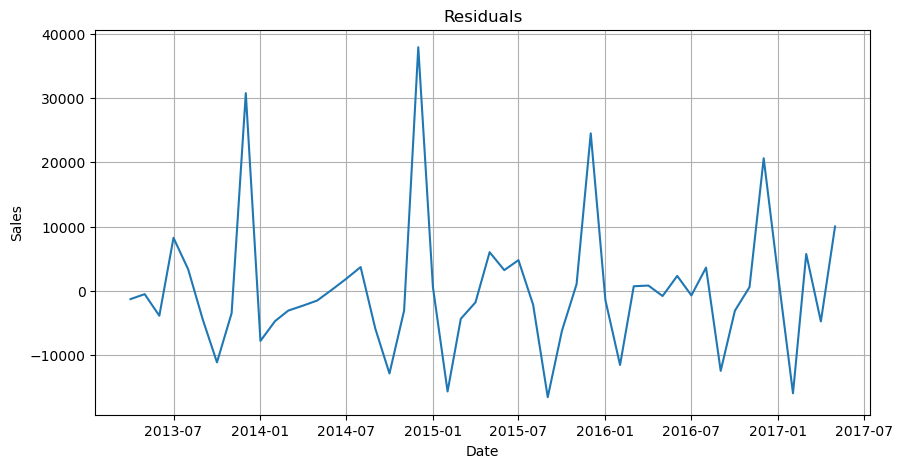

In [58]:
# Residuals diagnostics
residuals_monthly = plot_decompose_monthly.resid.dropna()
plt.figure(figsize=(10, 5))
plt.plot(residuals_monthly)
plt.title('Residuals')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.grid(True)
plt.show()

### Train Test Split

In [59]:
len(df_groceries_monthly)

56

In [60]:
# Train 80% Test 20%
train_size_monthly = int(0.8 * len(df_groceries_monthly))
train_monthly = df_groceries_monthly['Sales'][:train_size_monthly]
test_monthly = df_groceries_monthly['Sales'][train_size_monthly:]


In [61]:
train_monthly=pd.DataFrame(train_monthly)
# train_monthly.index = pd.to_datetime(train_monthly.index)
# train_monthly.index = pd.date_range(start=train_monthly.index.min(), periods=len(train_monthly), freq="D")
print(train_monthly,len(train_monthly))

                 Sales
Monthly               
2013-01-01   87781.000
2013-02-01   81817.000
2013-03-01   90864.000
2013-04-01   84845.000
2013-05-01   93442.000
2013-06-01   92643.000
2013-07-01   96113.000
2013-08-01  100339.000
2013-09-01   90746.000
2013-10-01   89387.000
2013-11-01   90782.000
2013-12-01  130898.000
2014-01-01   93298.000
2014-02-01   88927.000
2014-03-01   99207.000
2014-04-01   88548.000
2014-05-01   96234.000
2014-06-01   93391.000
2014-07-01  100701.000
2014-08-01  105157.000
2014-09-01   93967.000
2014-10-01   96336.000
2014-11-01   97815.000
2014-12-01  143899.000
2015-01-01  101078.000
2015-02-01   92293.000
2015-03-01  104437.000
2015-04-01   92220.000
2015-05-01  106283.000
2015-06-01   94707.000
2015-07-01   99615.000
2015-08-01   86888.000
2015-09-01   80591.000
2015-10-01   91498.000
2015-11-01   88271.000
2015-12-01  120809.760
2016-01-01   89769.898
2016-02-01   85298.000
2016-03-01   92429.000
2016-04-01   94704.000
2016-05-01   94561.000
2016-06-01 

In [62]:
test_monthly=pd.DataFrame(test_monthly)
# test_monthly.index = pd.to_datetime(test_monthly.index)
# test_monthly.index = pd.date_range(start=test_monthly.index.min(), periods=len(test_monthly), freq="D")
print(test_monthly,len(test_monthly))

               Sales
Monthly             
2016-09-01   83829.0
2016-10-01   88475.0
2016-11-01   96741.0
2016-12-01  118947.0
2017-01-01   92703.0
2017-02-01   83491.0
2017-03-01   97383.0
2017-04-01   89361.0
2017-05-01   92025.0
2017-06-01   91954.0
2017-07-01   99876.0
2017-08-01   44574.0 12


### Train Clean Up Data

In [63]:
# Sales Data Only
train_desc_monthly=pd.DataFrame(train_monthly.describe())

IQR = train_desc_monthly.loc['75%','Sales'] - train_desc_monthly.loc['25%','Sales']
train_upper_monthly = train_desc_monthly.loc['75%','Sales'] + 1.5*IQR

if train_desc_monthly.loc['25%','Sales'] - 1.5*IQR <0:
    train_lower_monthly = 0
else:
    train_lower_monthly = train_desc_monthly.loc['25%','Sales'] - 1.5*IQR

print(
    train_desc_monthly,
    '\n\nIQR = ', IQR,
    '\nUpper Limit = ', train_upper_monthly,
    '\nLower Limit = ', train_lower_monthly
)

               Sales
count      44.000000
mean    95830.992227
std     11630.955203
min     80591.000000
25%     89674.173500
50%     93344.500000
75%     98163.000000
max    143899.000000 

IQR =  8488.826499999996 
Upper Limit =  110896.23975 
Lower Limit =  76940.93375000001


### Data Cleaning

<Axes: xlabel='Monthly'>

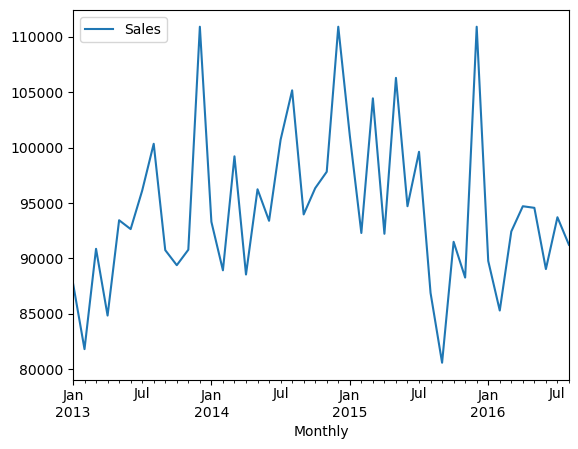

In [64]:
train_clean_monthly = pd.DataFrame(train_monthly)
train_clean_monthly['Sales'] = np.where(train_clean_monthly['Sales'] > train_upper_monthly,train_upper_monthly,train_clean_monthly['Sales'])
train_clean_monthly['Sales'] = np.where(train_clean_monthly['Sales'] < train_lower_monthly,train_lower_monthly,train_clean_monthly['Sales'])
# train_clean_monthly.index = pd.to_datetime(train_clean_monthly.index)
# train_clean_monthly.index = pd.date_range(start=train_clean_monthly.index.min(), periods=len(train_clean_monthly), freq="D")
train_clean_monthly.plot()

In [65]:
train_clean_monthly

Sales
Monthly                 
2013-01-01   87781.00000
2013-02-01   81817.00000
2013-03-01   90864.00000
2013-04-01   84845.00000
2013-05-01   93442.00000
2013-06-01   92643.00000
2013-07-01   96113.00000
2013-08-01  100339.00000
2013-09-01   90746.00000
2013-10-01   89387.00000
2013-11-01   90782.00000
2013-12-01  110896.23975
2014-01-01   93298.00000
2014-02-01   88927.00000
2014-03-01   99207.00000
2014-04-01   88548.00000
2014-05-01   96234.00000
2014-06-01   93391.00000
2014-07-01  100701.00000
2014-08-01  105157.00000
2014-09-01   93967.00000
2014-10-01   96336.00000
2014-11-01   97815.00000
2014-12-01  110896.23975
2015-01-01  101078.00000
2015-02-01   92293.00000
2015-03-01  104437.00000
2015-04-01   92220.00000
2015-05-01  106283.00000
2015-06-01   94707.00000
2015-07-01   99615.00000
2015-08-01   86888.00000
2015-09-01   80591.00000
2015-10-01   91498.00000
2015-11-01   88271.00000
2015-12-01  110896.23975
2016-01-01   89769.89800
2016-02-01   85298.00000
2016-03-01   92429.00000
2016-04-01   94704.00000
2016-05-01   94561.00000
2016-06-01   89038.00000
2016-07-01   93712.00000
2016-08-01   91224.00000

### ACF and PACF Plot

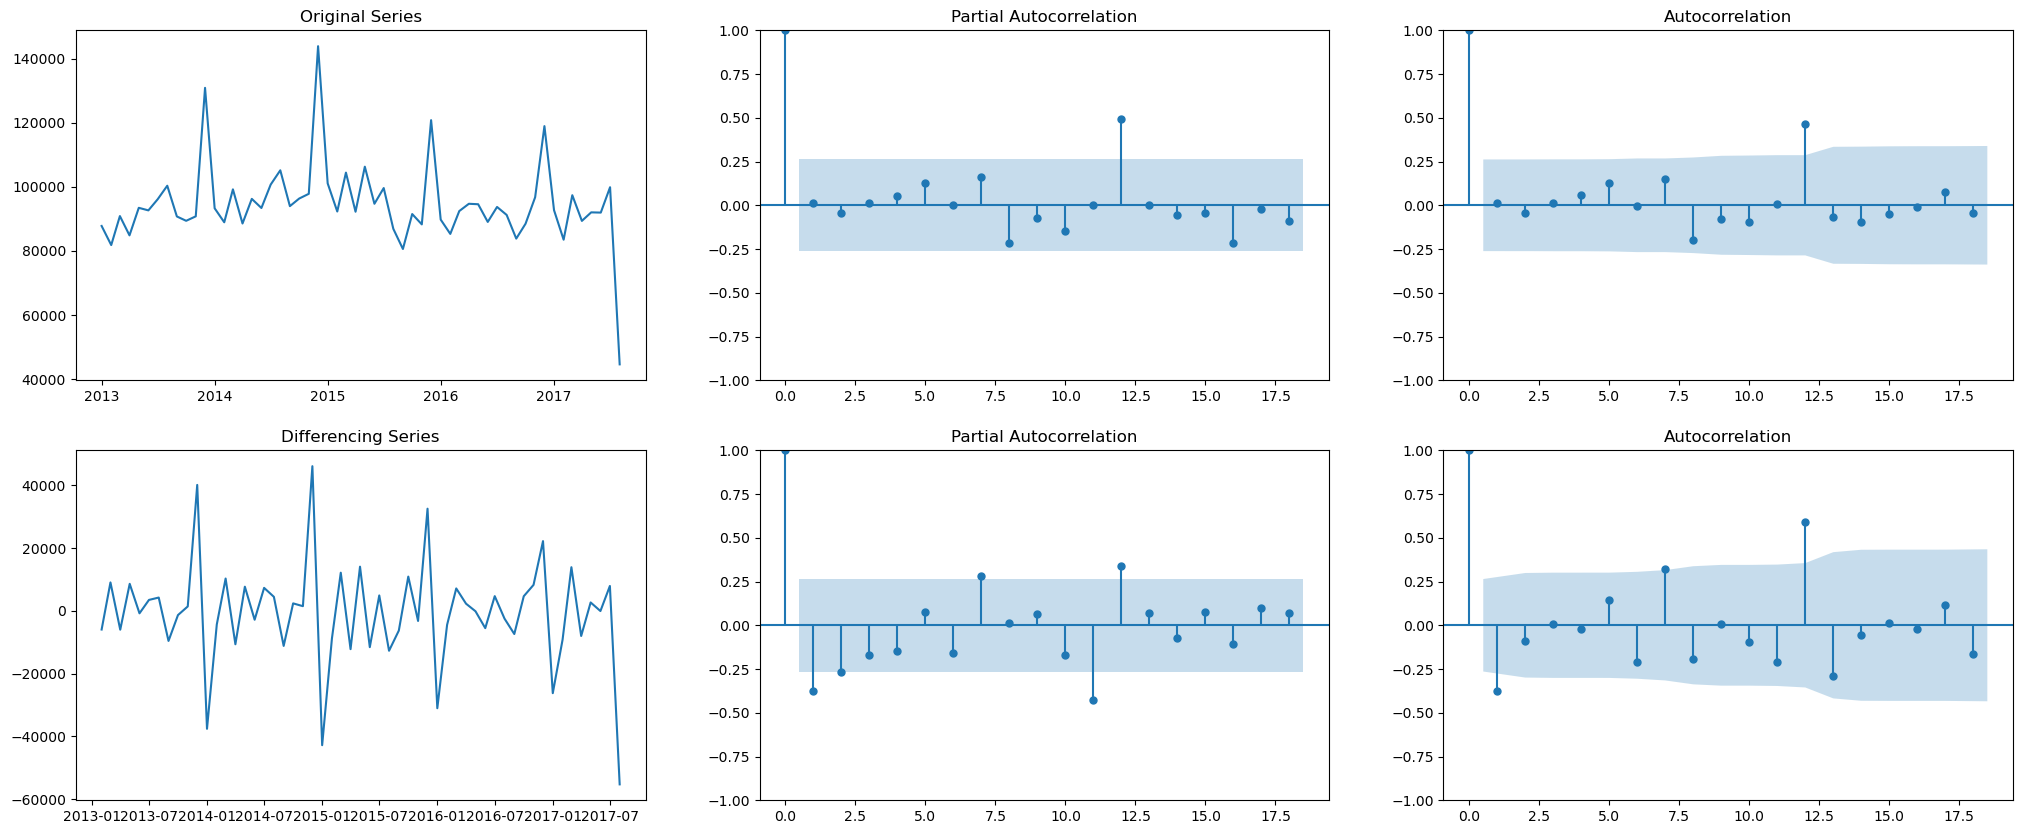

In [66]:
# Plot ACF dan PACF
fig, ax = plt.subplots(2, 3, figsize=(25, 10))

ax[0, 0].set_title('Original Series')
ax[0, 0].plot(df_groceries_monthly['Sales'])
ax[0, 1] = plot_pacf(df_groceries_monthly['Sales'], ax=ax[0, 1])
ax[0, 2] = plot_acf(df_groceries_monthly['Sales'], ax=ax[0, 2])

ax[1, 0].set_title('Differencing Series')
ax[1, 0].plot(df_groceries_monthly['Sales'].diff().dropna())
ax[1, 1] = plot_pacf(df_groceries_monthly['Sales'].diff().dropna(), ax=ax[1, 1])
ax[1, 2] = plot_acf(df_groceries_monthly['Sales'].diff().dropna(), ax=ax[1, 2])



plt.show()

### Define Order (p, d, q)

Dari PACF, kita bisa mengambilkan nilai AR(p) = 1,<br>
Dari ACF, kita bisa mengambilkan nilai MA(q) = 1,<br>
Dari hasil uji diagnostik, kita bisa mengambilkan nilai d = 1, <br>
Dari PACF, kita bisa mengambil kesimpulan seasonal = 12  
Dari data decompose 'Trend', kita bisa mengambil kesimpulan seasonal = 7 

### ARIMA Monthly 12

In [67]:
# ARIMA Model
arima_monthly_12 = ARIMA(train_clean_monthly, order=(1,1,1), seasonal_order=(1,1,1,12))
model_fit_arima_monthly_12 = arima_monthly_12.fit()
print(model_fit_arima_monthly_12.summary())

c:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'


                                    SARIMAX Results                                     
Dep. Variable:                            Sales   No. Observations:                   44
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                -315.360
Date:                          Mon, 02 Jun 2025   AIC                            640.720
Time:                                  19:10:08   BIC                            647.890
Sample:                              01-01-2013   HQIC                           643.058
                                   - 08-01-2016                                         
Covariance Type:                            opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1091      2.185     -0.050      0.960      -4.392       4.174
ma.L1          0.0458      2.212      0.021      0.

c:\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


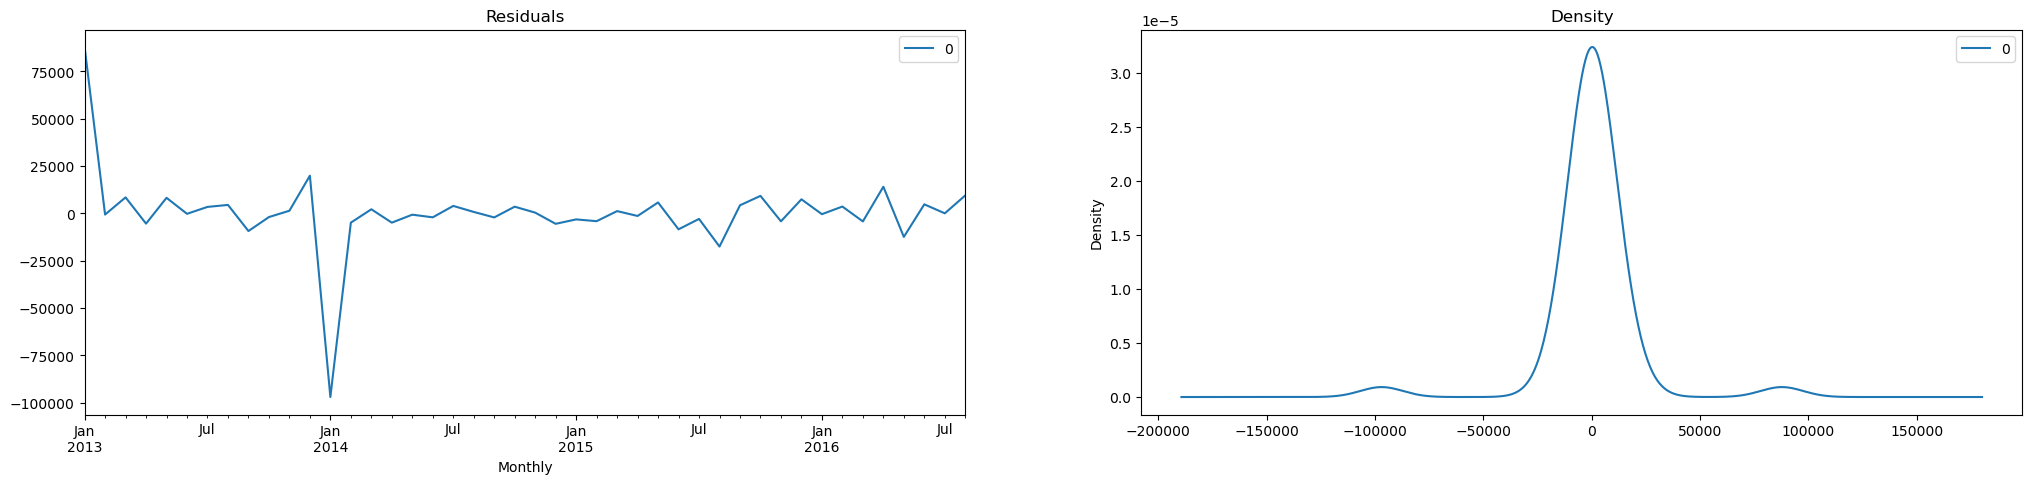

In [68]:
# Plot residual errors
residuals_arima_monthly_12 = pd.DataFrame(model_fit_arima_monthly_12.resid)
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals_arima_monthly_12.plot(title="Residuals", ax=ax[0])
residuals_arima_monthly_12.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

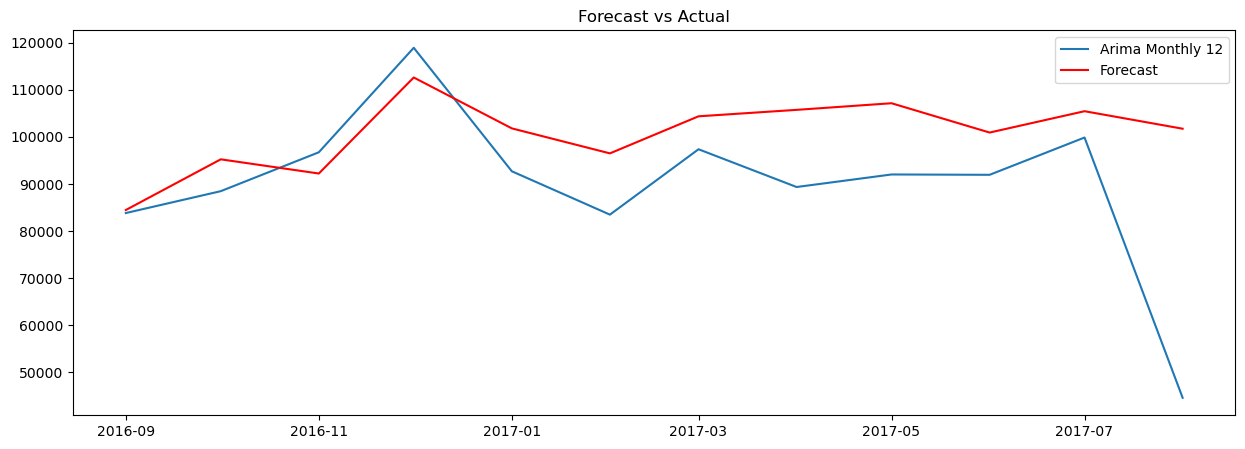

In [ ]:
# Prediction
predict_arima_monthly_12 = model_fit_arima_monthly_12.predict(start=len(train_monthly), end=len(df_groceries_monthly)-1, typ='levels')
predict_arima_monthly_12.index = test_monthly.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test_monthly, label='ARIMA Monthly 12')
plt.plot(predict_arima_monthly_12, label='Forecast', color='r')
plt.legend()

### ARIMA Monthly 7

In [70]:
# ARIMA Model
arima_monthly_7 = ARIMA(train_clean_monthly, order=(1,1,1), seasonal_order=(1,1,1,7))
model_fit_arima_monthly_7 = arima_monthly_7.fit()
print(model_fit_arima_monthly_7.summary())

c:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                    SARIMAX Results                                    
Dep. Variable:                           Sales   No. Observations:                   44
Model:             ARIMA(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood                -380.363
Date:                         Mon, 02 Jun 2025   AIC                            770.725
Time:                                 19:10:09   BIC                            778.643
Sample:                             01-01-2013   HQIC                           773.489
                                  - 08-01-2016                                         
Covariance Type:                           opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4956      1.414      0.350      0.726      -2.276       3.267
ma.L1         -0.5493      1.356     -0.405      0.685     

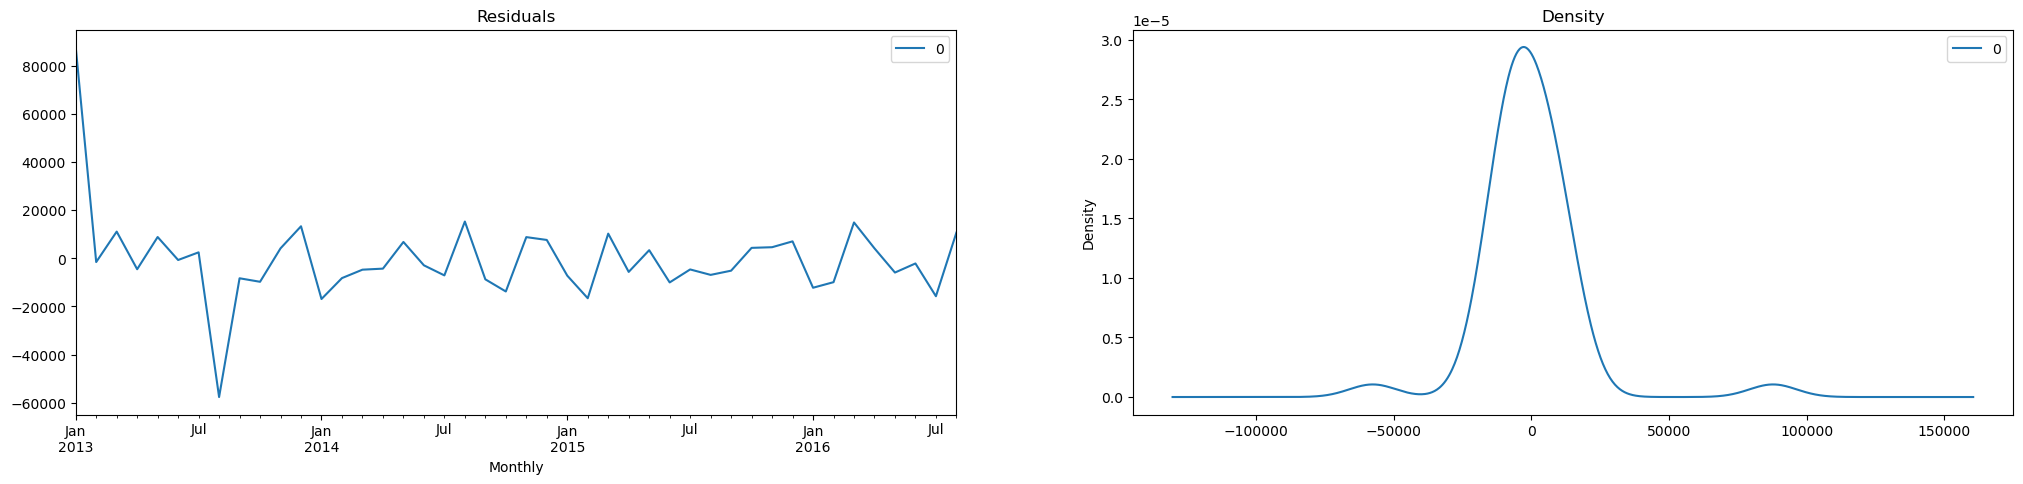

In [71]:
# Plot residual errors
residuals_arima_monthly_7 = pd.DataFrame(model_fit_arima_monthly_7.resid)
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals_arima_monthly_7.plot(title="Residuals", ax=ax[0])
residuals_arima_monthly_7.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

c:\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning: Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.
  warnings.warn(msg, FutureWarning)


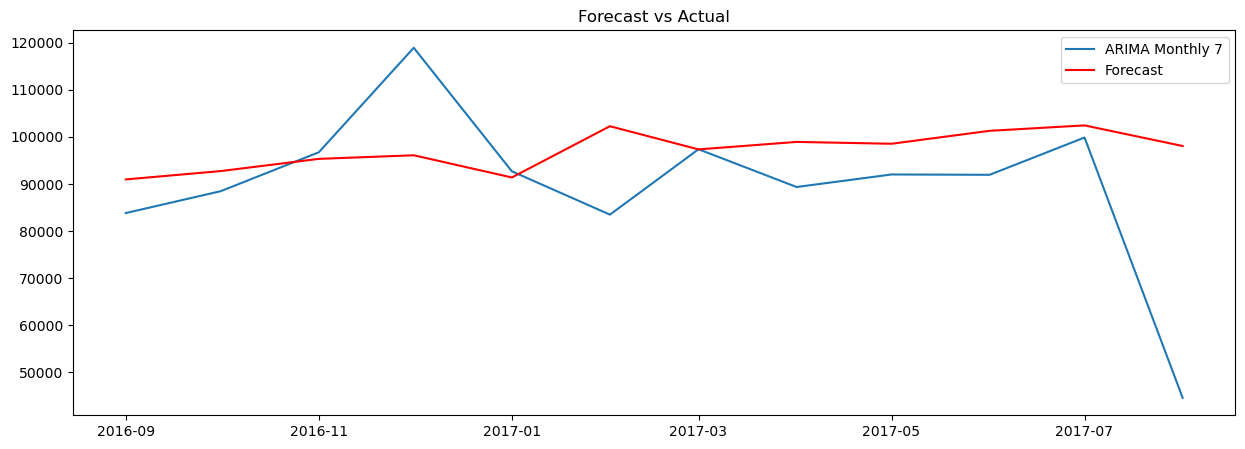

In [228]:
# Prediction
predict_arima_monthly_7 = model_fit_arima_monthly_7.predict(start=len(train_monthly), end=len(df_groceries_monthly)-1, typ='levels')
predict_arima_monthly_7.index = test_monthly.index

plt.figure(figsize=(15,5))
plt.title('Forecast vs Actual')
plt.plot(test_monthly, label='ARIMA Monthly 7')
plt.plot(predict_arima_monthly_7, label='Forecast', color='r')
plt.legend()

### Auto Arima Monthly

In [73]:
auto_arima_monthly = pm.auto_arima(train_clean_monthly,
                      start_p=0,        # nilai p pertama
                      start_q=0,        # nilai q pertama
                      test='adf',       # gunakan adftest untuk mencari optimal 'd'
                      max_p=12,          # maksimal p
                      max_q=12,          # maksimal q
                      d=0,           # let model determine 'd'
                      m=7,             # frequency of series
                      seasonal=True,    # Seasonality
                      start_P=0,        # nilai P pertama
                      D=0,           # let model determine 'D'
                      start_Q=0,        # nilai Q pertama
                      max_P=3,          # maksimal P
                      max_D=1,          # maksimal D
                      max_Q=3,          # maksimal Q
                      trace=True,       # print result
                      error_action='ignore',    # we don't want to know if an order does not work
                      suppress_warnings=True,   # we don't want convergence warnings
                      stepwise=True)        # set to stepwise

print(auto_arima_monthly.summary())

Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[7] intercept   : AIC=909.744, Time=0.01 sec
 ARIMA(1,0,0)(1,0,0)[7] intercept   : AIC=912.062, Time=0.05 sec
 ARIMA(0,0,1)(0,0,1)[7] intercept   : AIC=907.852, Time=0.01 sec
 ARIMA(0,0,0)(0,0,0)[7]             : AIC=1135.185, Time=0.01 sec
 ARIMA(0,0,1)(0,0,0)[7] intercept   : AIC=911.713, Time=0.01 sec
 ARIMA(0,0,1)(1,0,1)[7] intercept   : AIC=909.536, Time=0.10 sec
 ARIMA(0,0,1)(0,0,2)[7] intercept   : AIC=909.839, Time=0.02 sec
 ARIMA(0,0,1)(1,0,0)[7] intercept   : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(1,0,2)[7] intercept   : AIC=911.534, Time=0.12 sec
 ARIMA(0,0,0)(0,0,1)[7] intercept   : AIC=907.717, Time=0.01 sec
 ARIMA(0,0,0)(1,0,1)[7] intercept   : AIC=909.651, Time=0.04 sec
 ARIMA(0,0,0)(0,0,2)[7] intercept   : AIC=909.063, Time=0.06 sec
 ARIMA(0,0,0)(1,0,0)[7] intercept   : AIC=911.730, Time=0.02 sec
 ARIMA(0,0,0)(1,0,2)[7] intercept   : AIC=911.422, Time=0.10 sec
 ARIMA(1,0,0)(0,0,1)[7] intercept   : AIC=908.483,

In [74]:
predict_auto_arima_monthly = auto_arima_monthly.predict(n_periods=len(test_monthly))
# predict_auto_arima_monthly = predict_auto_arima_monthly.reindex(test_monthly.index)
predict_auto_arima_monthly

2016-09-01    91121.920875
2016-10-01    95027.245307
2016-11-01    96253.629533
2016-12-01    95144.143958
2017-01-01    93121.396873
2017-02-01    92499.840977
2017-03-01    93773.098571
2017-04-01    94401.036726
2017-05-01    94401.036726
2017-06-01    94401.036726
2017-07-01    94401.036726
2017-08-01    94401.036726
Freq: MS, dtype: float64

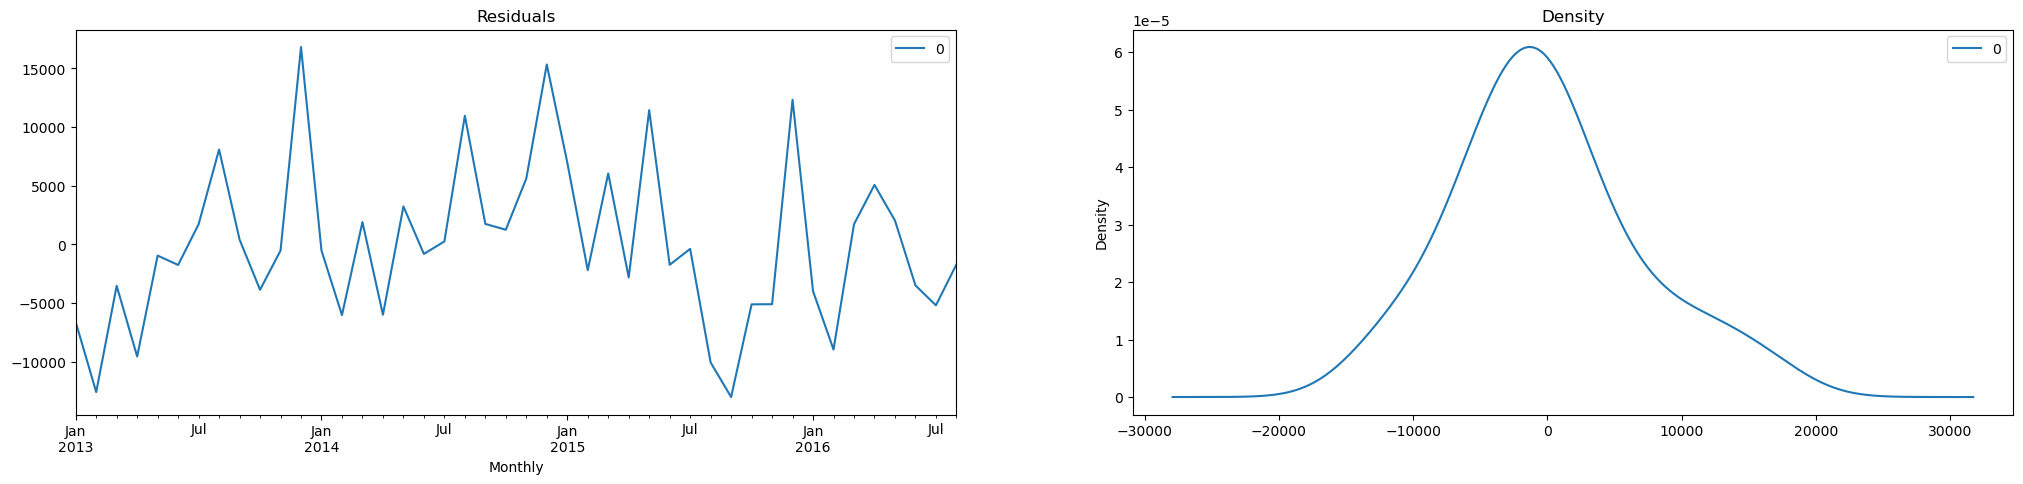

In [75]:
residuals_auto_arima_monthly = pd.DataFrame(auto_arima_monthly.resid())
fig, ax = plt.subplots(1,2, figsize=(25,5))
residuals_auto_arima_monthly.plot(title="Residuals", ax=ax[0])
residuals_auto_arima_monthly.plot(kind='kde', title='Density', ax=ax[1])
plt.show()

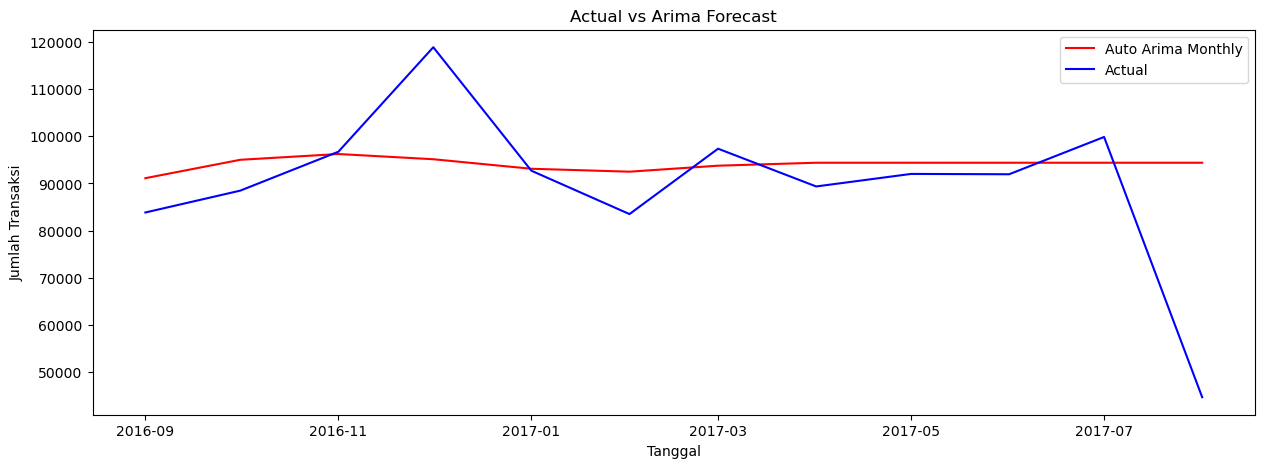

In [76]:
plt.figure(figsize=(15,5))
plt.plot(predict_auto_arima_monthly, color='red', label='Auto Arima Monthly')
plt.plot(test_monthly, color='blue', label='Actual')
plt.title('Actual vs Arima Forecast')
plt.xlabel('Tanggal')
plt.ylabel('Jumlah Transaksi')
plt.legend()

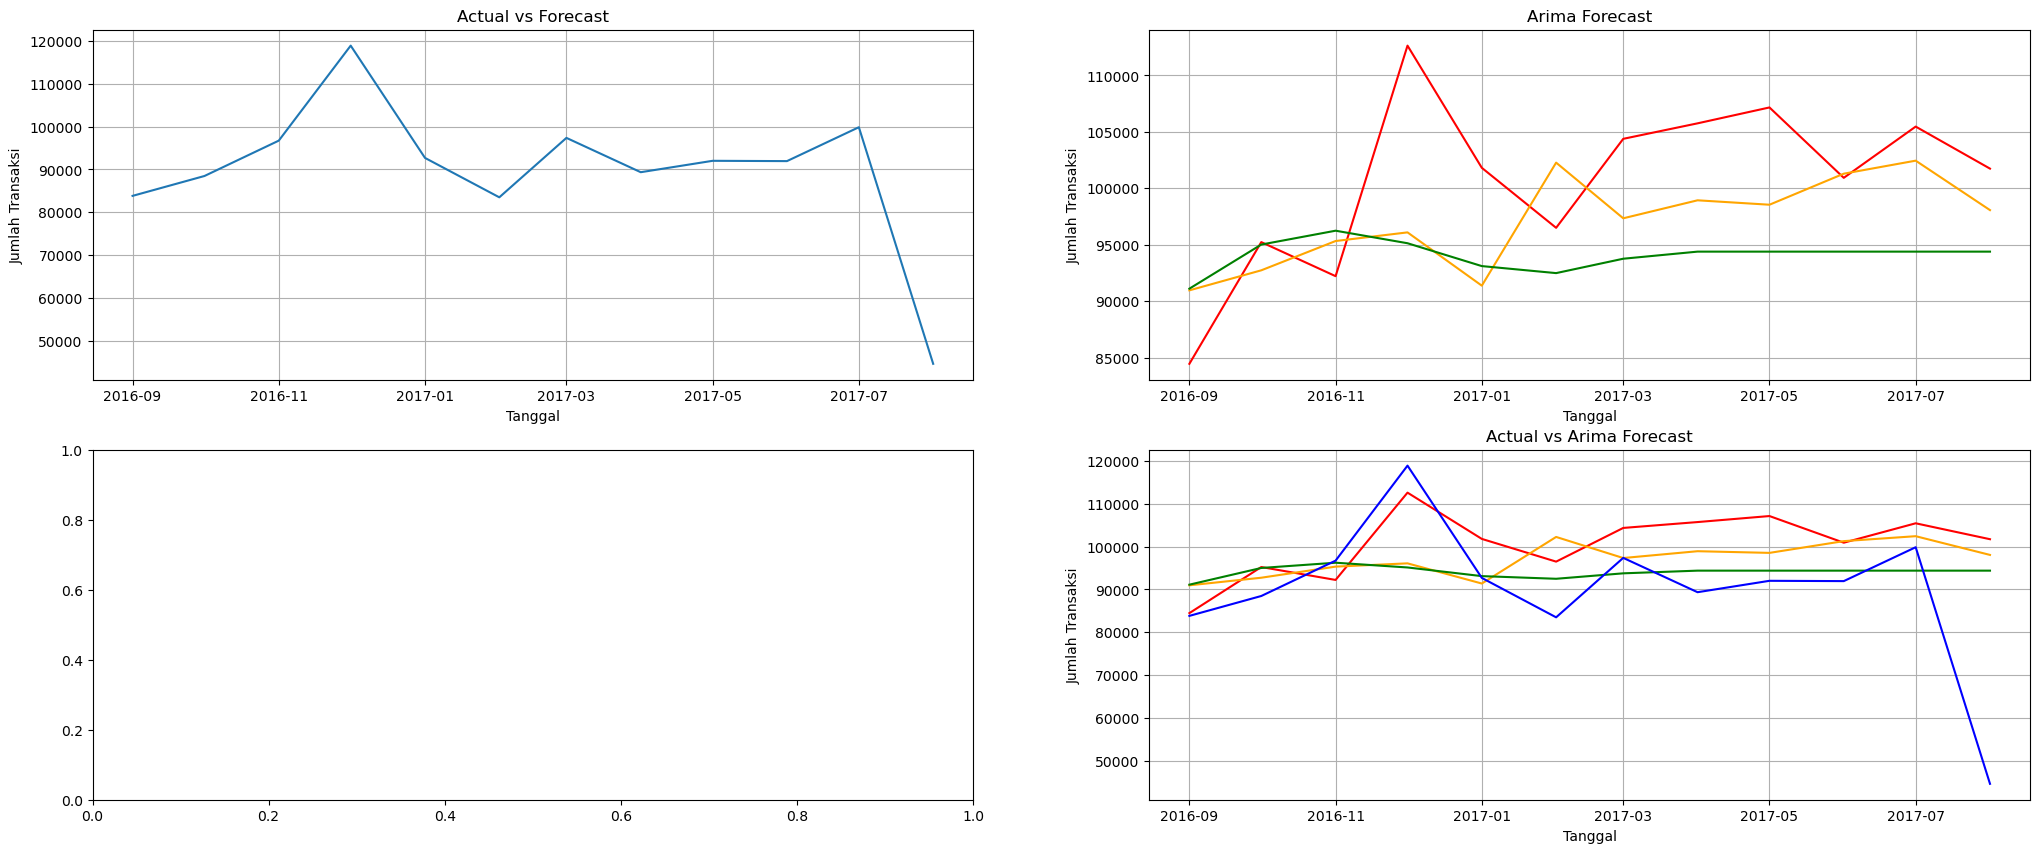

In [77]:
# Predict data
start_index_monthly = 0
end_index_monthly = len(df_groceries_monthly)+12

# Forecast using previous forecast function

# Actual
actual_monthly = test_monthly

# Plot actual vs forecast
fig, ax = plt.subplots(2, 2, figsize=(25, 10))
ax[0,0].plot(actual_monthly)
ax[0,0].set_title('Actual vs Forecast')
ax[0,0].set_xlabel('Tanggal')
ax[0,0].set_ylabel('Jumlah Transaksi')
ax[0,0].grid(True)

ax[0,1].plot(predict_arima_monthly_12, color='red', label='Arima Daily 365')
ax[0,1].plot(predict_arima_monthly_7, color='orange', label='Arima Daily 7')
ax[0,1].plot(predict_auto_arima_monthly, color='green', label='Auto Arima Daily')
ax[0,1].set_title('Arima Forecast')
ax[0,1].set_xlabel('Tanggal')
ax[0,1].set_ylabel('Jumlah Transaksi')
ax[0,1].grid(True)


ax[1,1].plot(predict_arima_monthly_12, color='red', label='Arima Monthly 12')
ax[1,1].plot(predict_arima_monthly_7, color='orange', label='Arima Monthly 7')
ax[1,1].plot(predict_auto_arima_monthly, color='green', label='Auto Arima Monthly')
ax[1,1].plot(actual_monthly, color='blue')
ax[1,1].set_title('Actual vs Arima Forecast')
ax[1,1].set_xlabel('Tanggal')
ax[1,1].set_ylabel('Jumlah Transaksi')
ax[1,1].grid(True)

### LSTM

#### Scaller

In [78]:
scaler_monthly = MinMaxScaler()
train_monthly.head(), test_monthly.head()

(              Sales
 Monthly            
 2013-01-01  87781.0
 2013-02-01  81817.0
 2013-03-01  90864.0
 2013-04-01  84845.0
 2013-05-01  93442.0,
                Sales
 Monthly             
 2016-09-01   83829.0
 2016-10-01   88475.0
 2016-11-01   96741.0
 2016-12-01  118947.0
 2017-01-01   92703.0)

#### LSTM Training

In [79]:
trainLSTM_monthly = train_monthly.values.reshape(-1, 1)
testLSTM_monthly = test_monthly.values.reshape(-1, 1)
series_testLSTM_monthly = test_monthly.values.reshape(-1)
series_testLSTM_monthly = pd.Series(series_testLSTM_monthly)
series_testLSTM_monthly.index = test_monthly.index

scaler_monthly.fit(trainLSTM_monthly)
# reshape the data
scaled_train_monthly = scaler_monthly.transform(trainLSTM_monthly)
scaled_test_monthly = scaler_monthly.transform(testLSTM_monthly)
scaled_all_monthly = scaler_monthly.transform(actual_monthly)

c:\anaconda3\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


In [80]:
series_testLSTM_monthly

Monthly
2016-09-01     83829.0
2016-10-01     88475.0
2016-11-01     96741.0
2016-12-01    118947.0
2017-01-01     92703.0
2017-02-01     83491.0
2017-03-01     97383.0
2017-04-01     89361.0
2017-05-01     92025.0
2017-06-01     91954.0
2017-07-01     99876.0
2017-08-01     44574.0
dtype: float64

In [81]:
scaled_train_monthly[:10]

array([[0.11357174],
       [0.01936564],
       [0.16227017],
       [0.0671953 ],
       [0.20299172],
       [0.19037089],
       [0.24518228],
       [0.3119353 ],
       [0.16040627],
       [0.13893979]])

In [234]:
# Fine Tuning Parameter

n_input_monthly = 10
n_features_monthly = 1
batch_size_monthly = 1
epoch_size_monthly = [10, 50, 100, 200, 300]

In [235]:
generator_monthly = TimeseriesGenerator(scaled_train_monthly, scaled_train_monthly, length=n_input_monthly, batch_size=batch_size_monthly)
val_generator_monthly = TimeseriesGenerator(scaled_test_monthly, scaled_test_monthly, length=n_input_monthly, batch_size=batch_size_monthly)


# define model
model_LSTM_monthly = Sequential()
model_LSTM_monthly.add(LSTM(50, input_shape=(n_input_monthly, n_features_monthly)))
model_LSTM_monthly.add(Dense(1))
model_LSTM_monthly.compile(optimizer='adam', loss='mse')

model_LSTM_monthly.summary()

C:\Users\Ryan Mahendradani\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 50)             │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [236]:
# fit model
early_stopping_monthly = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
# model_LSTM_monthly.fit(generator_monthly, epochs=epoch_size_monthly, validation_data=val_generator_monthly, callbacks=[early_stopping_monthly])

for epoch_size_monthly in epoch_size_monthly:
    history_monthly = model_LSTM_monthly.fit(generator_monthly, epochs=epoch_size_monthly, validation_data=val_generator_monthly)
    print(f"Epoch {epoch_size_monthly} - Final Validation Loss: {history_monthly.history['val_loss'][-1]}")



Epoch 1/10


C:\Users\Ryan Mahendradani\AppData\Roaming\Python\Python312\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 0.0449 - val_loss: 0.3581
Epoch 2/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0296 - val_loss: 0.3103
Epoch 3/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0446 - val_loss: 0.3053
Epoch 4/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0387 - val_loss: 0.3439
Epoch 5/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0505 - val_loss: 0.3064
Epoch 6/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0216 - val_loss: 0.3365
Epoch 7/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0132 - val_loss: 0.3232
Epoch 8/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0447 - val_loss: 0.3036
Epoch 9/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0488 - val_loss: 0.3173
Epoch 10/10
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.0339 - val_loss: 0.3411
Epoch 10 - Final Validation Loss: 0.3411237597465515
Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.0146 - val_loss: 0.3282
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━

In [237]:
trainpredict_monthly = model_LSTM_monthly.predict(scaled_train_monthly)
testpredict_monthly = model_LSTM_monthly.predict(scaled_test_monthly)

# Reshape trainPredict and testPredict for plotting
trainpredict_monthly = trainpredict_monthly.reshape(-1, 1)
testpredict_monthly = testpredict_monthly.reshape(-1, 1)

trainpredict_monthly = scaler_monthly.inverse_transform(trainpredict_monthly)
trainactual_monthly = scaler_monthly.inverse_transform(scaled_train_monthly)
testpredict_monthly = scaler_monthly.inverse_transform(testpredict_monthly)
testactual_monthly = scaler_monthly.inverse_transform(scaled_test_monthly)

predict_LSTM_monthly = testpredict_monthly.copy()
predict_LSTM_monthly = predict_LSTM_monthly.reshape(-1,1)
actual_LSTM_monthly = testactual_monthly.copy()
actual_LSTM_monthly = actual_LSTM_monthly.reshape(-1, 1)
print(predict_LSTM_monthly.shape)
print(actual_LSTM_monthly.shape)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
(12, 1)
(12, 1)


#### Predictions

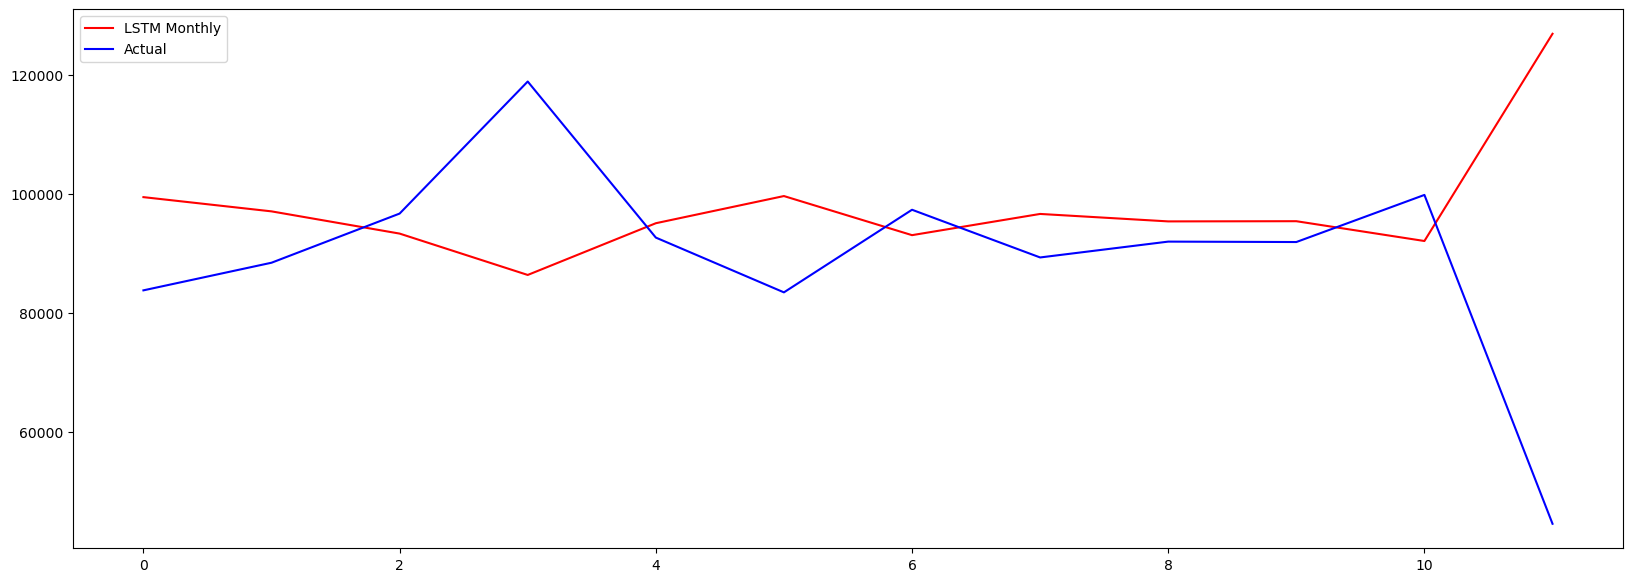

In [238]:
plt.figure(figsize=(20,7))
plt.plot(pd.DataFrame(predict_LSTM_monthly), label='LSTM Monthly', color= 'red')
plt.plot(pd.DataFrame(actual_LSTM_monthly), label='Actual', color= 'blue')
plt.legend(loc='best')
plt.show()

# Comparison Model

### Evaluation

In [246]:
mask = actual['Sales'] != 0
mask2 = actual_monthly['Sales'] != 0


MAPE_365 = mean_absolute_percentage_error(actual['Sales'][mask],predict_arima_daily_365[mask])*100
MAE_365 = mean_absolute_error(actual['Sales'],predict_arima_daily_365)
RMSE_365 = root_mean_squared_error(actual['Sales'],predict_arima_daily_365)
R2_365 = r2_score(actual['Sales'],predict_arima_daily_365)

MAPE_7 = mean_absolute_percentage_error(actual['Sales'][mask],predict_arima_daily_7[mask])*100
MAE_7 = mean_absolute_error(actual['Sales'],predict_arima_daily_7)
RMSE_7 = root_mean_squared_error(actual['Sales'],predict_arima_daily_7)
R2_7 = r2_score(actual['Sales'],predict_arima_daily_7)

MAPE_auto = mean_absolute_percentage_error(actual['Sales'][mask],predict_auto_arima_daily[mask])*100
MAE_auto = mean_absolute_error(actual['Sales'],predict_auto_arima_daily)
RMSE_auto = root_mean_squared_error(actual['Sales'],predict_auto_arima_daily)
R2_auto = r2_score(actual['Sales'],predict_auto_arima_daily)

MAPE_LSTM = mean_absolute_percentage_error(actual['Sales'][mask],predict_LSTM_daily[mask])*100
MAE_LSTM = mean_absolute_error(actual['Sales'],predict_LSTM_daily)
RMSE_LSTM = root_mean_squared_error(actual['Sales'],predict_LSTM_daily)
R2_LSTM = r2_score(actual['Sales'],predict_LSTM_daily)

MAPE_12_monthly = mean_absolute_percentage_error(actual_monthly['Sales'][mask2],predict_arima_monthly_12[mask2])*100
MAE_12_monthly = mean_absolute_error(actual_monthly['Sales'],predict_arima_monthly_12)
RMSE_12_monthly = root_mean_squared_error(actual_monthly['Sales'],predict_arima_monthly_12)
R2_12_monthly = r2_score(actual_monthly['Sales'],predict_arima_monthly_12)

MAPE_7_monthly = mean_absolute_percentage_error(actual_monthly['Sales'][mask2],predict_arima_monthly_7[mask2])*100
MAE_7_monthly = mean_absolute_error(actual_monthly['Sales'],predict_arima_monthly_7)
RMSE_7_monthly = root_mean_squared_error(actual_monthly['Sales'],predict_arima_monthly_7)
R2_7_monthly = r2_score(actual_monthly['Sales'],predict_arima_monthly_7)

MAPE_auto_monthly = mean_absolute_percentage_error(actual_monthly['Sales'][mask2],predict_auto_arima_monthly[mask2])*100
MAE_auto_monthly = mean_absolute_error(actual_monthly['Sales'],predict_auto_arima_monthly)
RMSE_auto_monthly = root_mean_squared_error(actual_monthly['Sales'],predict_auto_arima_monthly)
R2_auto_monthly = r2_score(actual_monthly['Sales'],predict_auto_arima_monthly)

MAPE_LSTM_monthly = mean_absolute_percentage_error(actual_monthly['Sales'][mask2],predict_LSTM_monthly[mask2])*100
MAE_LSTM_monthly = mean_absolute_error(actual_monthly['Sales'],predict_LSTM_monthly)
RMSE_LSTM_monthly = root_mean_squared_error(actual_monthly['Sales'],predict_LSTM_monthly)
R2_LSTM_monthly = r2_score(actual_monthly['Sales'],predict_LSTM_monthly)

Summary = {
    'Category' : ['ARIMA Daily 365','Arima Daily 7','Auto Arima Daily','LSTM Daily','ARIMA Monthly 12','Arima Monthly 7','Auto Arima Monthly','LSTM Monthly'],
    'MAPE' : [MAPE_365,MAPE_7,MAPE_auto,MAPE_LSTM,MAPE_12_monthly,MAPE_7_monthly,MAPE_auto_monthly,MAPE_LSTM_monthly],
    'MAE' : [MAE_365,MAE_7,MAE_auto,MAE_LSTM,MAE_12_monthly,MAE_7_monthly,MAE_auto_monthly,MAE_LSTM_monthly],
    'RMSE' : [RMSE_365,RMSE_7,RMSE_auto,RMSE_LSTM,RMSE_12_monthly,RMSE_7_monthly,RMSE_auto_monthly,RMSE_LSTM_monthly],
}
Summary = pd.DataFrame(Summary).set_index('Category')


# RMSE_min = 
# R2_min = 

print('MAPE ARIMA 365 = ',(f"{MAPE_365:.2f}%"),
      '\nMAE ARIMA 365 = ',(f"{MAE_365:.2f}"),
      '\nRMSE ARIMA 365 = ',(f"{RMSE_365:.2f}"),
      '\n\nMAPE ARIMA 7 = ',(f"{MAPE_7:.2f}%"),
      '\nMAE ARIMA 7 = ',(f"{MAE_7:.2f}"),
      '\nRMSE ARIMA 7 = ',(f"{RMSE_7:.2f}"),
      '\n\nMAPE Auto ARIMA = ',(f"{MAPE_auto:.2f}%"),
      '\nMAE Auto ARIMA = ',(f"{MAE_auto:.2f}"),
      '\nRMSE Auto ARIMA = ',(f"{RMSE_auto:.2f}"),
      '\n\nMAPE LSTM = ',(f"{MAPE_LSTM:.2f}%"),
      '\nMAE LSTM = ',(f"{MAE_LSTM:.2f}"),
      '\nRMSE LSTM = ',(f"{RMSE_LSTM:.2f}"),
      '\n\nMAPE ARIMA Monthly 12 = ',(f"{MAPE_12_monthly:.2f}%"),
      '\nMAE ARIMA Monthly 12 = ',(f"{MAE_12_monthly:.2f}"),
      '\nRMSE ARIMA Monthly 12 = ',(f"{RMSE_12_monthly:.2f}"),
      '\n\nMAPE ARIMA Monthly 7 = ',(f"{MAPE_7_monthly:.2f}%"),
      '\nMAE ARIMA Monthly 7 = ',(f"{MAE_7_monthly:.2f}"),
      '\nRMSE ARIMA Monthly 7 = ',(f"{RMSE_7_monthly:.2f}"),
      '\n\nMAPE Auto ARIMA Monthly = ',(f"{MAPE_auto_monthly:.2f}%"),
      '\nMAE Auto ARIMA Monthly = ',(f"{MAE_auto_monthly:.2f}"),
      '\nRMSE Auto ARIMA Monthly = ',(f"{RMSE_auto_monthly:.2f}"),
      '\n\nMAPE LSTM Monthly = ',(f"{MAPE_LSTM_monthly:.2f}%"),
      '\nMAE LSTM Monthly = ',(f"{MAE_LSTM_monthly:.2f}"),
      '\nRMSE LSTM Monthly = ',(f"{RMSE_LSTM_monthly:.2f}")
      )

MAPE ARIMA 365 =  15.99% 
MAE ARIMA 365 =  509.51 
RMSE ARIMA 365 =  701.40 

MAPE ARIMA 7 =  13.02% 
MAE ARIMA 7 =  434.05 
RMSE ARIMA 7 =  635.69 

MAPE Auto ARIMA =  18.09% 
MAE Auto ARIMA =  589.30 
RMSE Auto ARIMA =  774.28 

MAPE LSTM =  7.80% 
MAE LSTM =  226.39 
RMSE LSTM =  285.35 

MAPE ARIMA Monthly 12 =  19.12% 
MAE ARIMA Monthly 12 =  12554.12 
RMSE ARIMA Monthly 12 =  18900.42 

MAPE ARIMA Monthly 7 =  17.38% 
MAE ARIMA Monthly 7 =  11444.17 
RMSE ARIMA Monthly 7 =  18345.31 

MAPE Auto ARIMA Monthly =  14.98% 
MAE Auto ARIMA Monthly =  9694.80 
RMSE Auto ARIMA Monthly =  16600.81 

MAPE LSTM Monthly =  24.50% 
MAE LSTM Monthly =  15621.96 
RMSE LSTM Monthly =  26776.41


In [240]:
Summary

MAPE           MAE          RMSE
Category                                                 
ARIMA Daily 365     15.990586    509.514655    701.396566
Arima Daily 7       13.018163    434.049301    635.692635
Auto Arima Daily    18.094961    589.298621    774.275163
LSTM Daily           7.800415    226.391062    285.350773
ARIMA Monthly 12    19.119256  12554.115774  18900.419547
Arima Monthly 7     17.378982  11444.167712  18345.308551
Auto Arima Monthly  14.976582   9694.803512  16600.808415
LSTM Monthly        24.499753  15621.962891  26776.410614

In [241]:
Summary.describe()

MAPE           MAE          RMSE
count   8.000000      8.000000      8.000000
mean   16.359837   6384.287941  10377.457783
std     4.846238   6561.611375  10865.299676
min     7.800415    226.391062    285.350773
25%    14.486977    490.648317    684.970583
50%    16.684784   5142.051067   8687.541789
75%    18.351035  11721.654727  18484.086300
max    24.499753  15621.962891  26776.410614

In [242]:
min_values = Summary.idxmin()
min_values = pd.DataFrame(min_values)


print(min_values)

               0
MAPE  LSTM Daily
MAE   LSTM Daily
RMSE  LSTM Daily


In [243]:
best_model = min_values.value_counts().idxmax()
print(f'Best Model = {best_model}')


Best Model = ('LSTM Daily',)


### Forecasting (Optional)

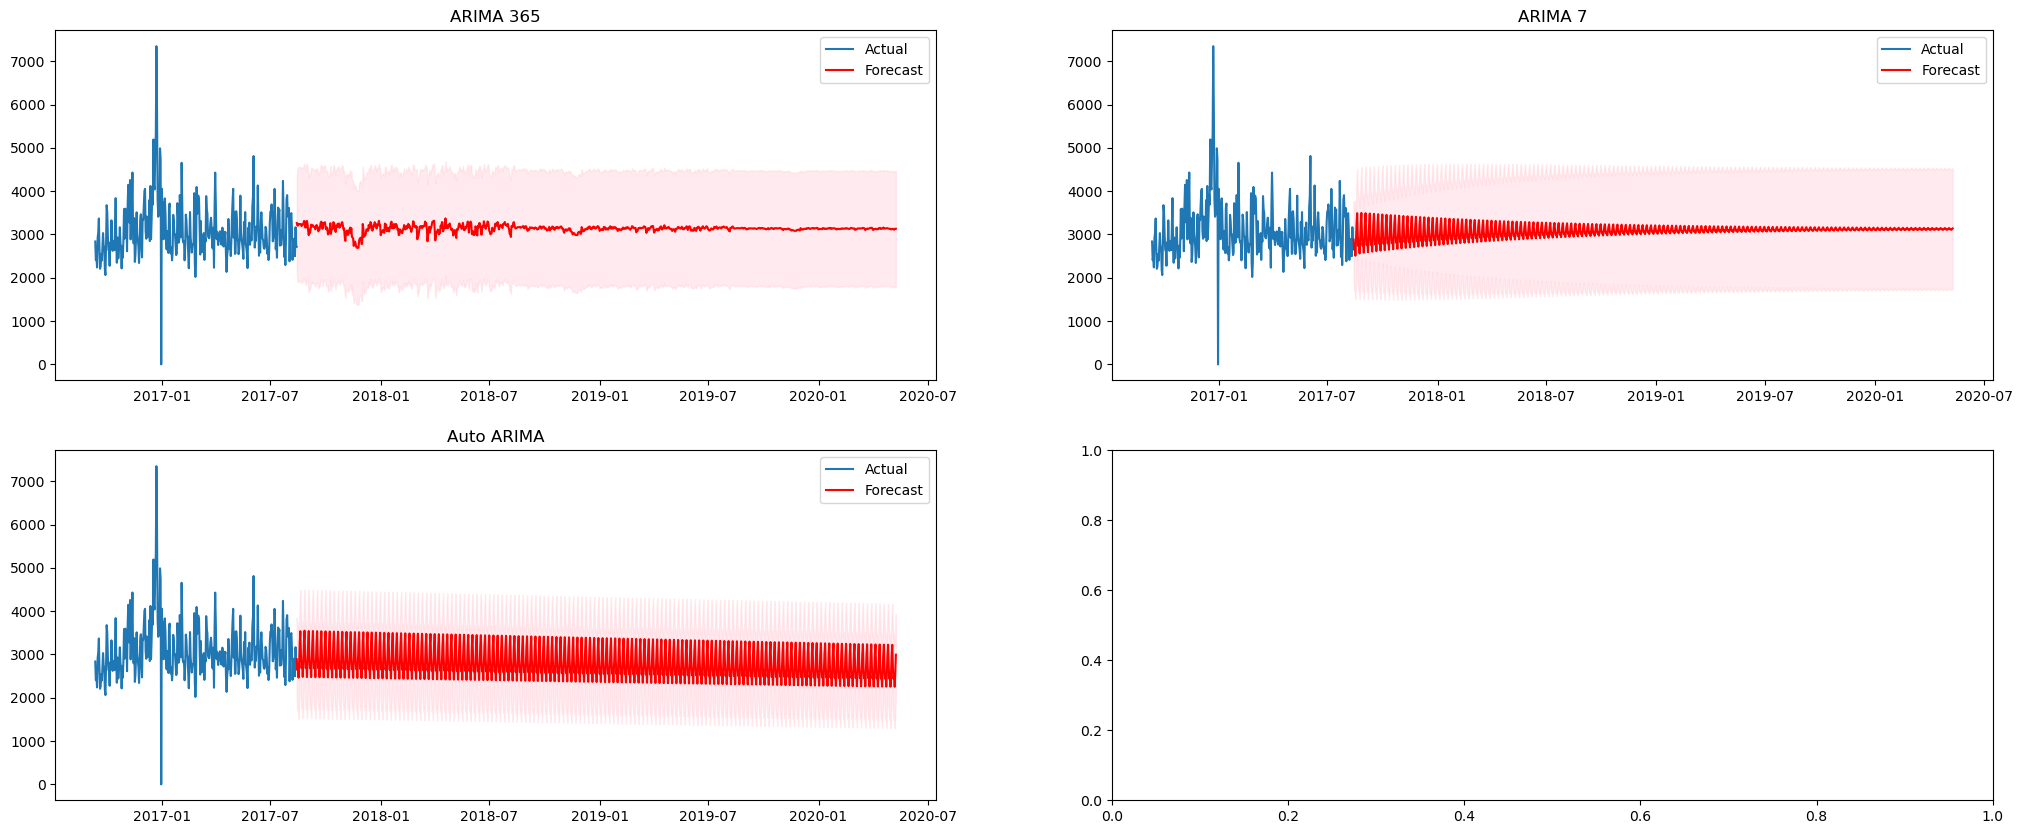

In [244]:
no_days = 1000



forecast_arima_daily_365 = model_fit_arima_daily_365.get_forecast(steps=no_days) 
forecast_values_arima_daily_365 = forecast_arima_daily_365.predicted_mean
confidence_intervals_arima_daily_365 = forecast_arima_daily_365.conf_int()

forecast_arima_daily_7 = model_fit_arima_daily_7.get_forecast(steps=no_days) 
forecast_values_arima_daily_7 = forecast_arima_daily_7.predicted_mean
confidence_intervals_arima_daily_7 = forecast_arima_daily_7.conf_int()

# hybrid average 365 & 7
# forecast_arima_daily_hybrid = (forecast_arima_daily_365+forecast_arima_daily_7)/2

forecast_auto_arima_daily = pd.DataFrame(auto_arima_daily.predict(n_periods=no_days))
forecast_values_auto_arima_daily = forecast_auto_arima_daily
confidence_intervals_auto_arima_daily = np.column_stack([
    forecast_values_auto_arima_daily - 1.96 * auto_arima_daily.resid().std(),
    forecast_values_auto_arima_daily + 1.96 * auto_arima_daily.resid().std()
])




# forecast_LSTM_daily = model_LSTM_daily.predict(actual)
# forecast_values_LSTM_daily = forecast_LSTM_daily
# confidence_intervals_LSTM_daily = np.column_stack([
#     forecast_values_LSTM_daily - 1.96 * predict_LSTM_daily.resid().std(),
#     forecast_values_LSTM_daily + 1.96 * predict_LSTM_daily.resid().std()
# ])

fig, ax = plt.subplots(2, 2, figsize=(25, 10))
ax[0,0].plot(test_daily.index, test_daily["Sales"], label="Actual")
ax[0,0].plot(pd.date_range(test_daily.index[-1], periods=1000, freq="D"), forecast_values_arima_daily_365, label="Forecast", color="red")
ax[0,0].set_title('ARIMA 365')
ax[0,0].fill_between(pd.date_range(test_daily.index[-1], periods=1000, freq="D"), confidence_intervals_arima_daily_365.iloc[:,0], confidence_intervals_arima_daily_365.iloc[:,1], color="pink", alpha=0.3)
ax[0,0].legend()

ax[0,1].plot(test_daily.index, test_daily["Sales"], label="Actual")
ax[0,1].plot(pd.date_range(test_daily.index[-1], periods=1000, freq="D"), forecast_values_arima_daily_7, label="Forecast", color="red")
ax[0,1].set_title('ARIMA 7')
ax[0,1].fill_between(pd.date_range(test_daily.index[-1], periods=1000, freq="D"), confidence_intervals_arima_daily_7.iloc[:,0], confidence_intervals_arima_daily_7.iloc[:,1], color="pink", alpha=0.3)
ax[0,1].legend()

ax[1,0].plot(test_daily.index, test_daily["Sales"], label="Actual")
ax[1,0].plot(pd.date_range(test_daily.index[-1], periods=1000, freq="D"), forecast_values_auto_arima_daily, label="Forecast", color="red")
ax[1,0].set_title('Auto ARIMA')
ax[1,0].fill_between(pd.date_range(test_daily.index[-1], periods=1000, freq="D"), confidence_intervals_auto_arima_daily[:,0], confidence_intervals_auto_arima_daily[:,1], color="pink", alpha=0.3)
ax[1,0].legend()

# ax[1,1].plot(test_daily.index, test_daily["Sales"], label="Actual")
# ax[1,1].plot(pd.date_range(test_daily.index[-1], periods=1000, freq="D"), forecast_LSTM_daily, label="Forecast", color="red")
# ax[1,1].set_title('LSTM')
# ax[1,1].fill_between(pd.date_range(test_daily.index[-1], periods=1000, freq="D"), confidence_intervals_auto_arima_daily[:,0], confidence_intervals_auto_arima_daily[:,1], color="pink", alpha=0.3)
# ax[1,1].legend()

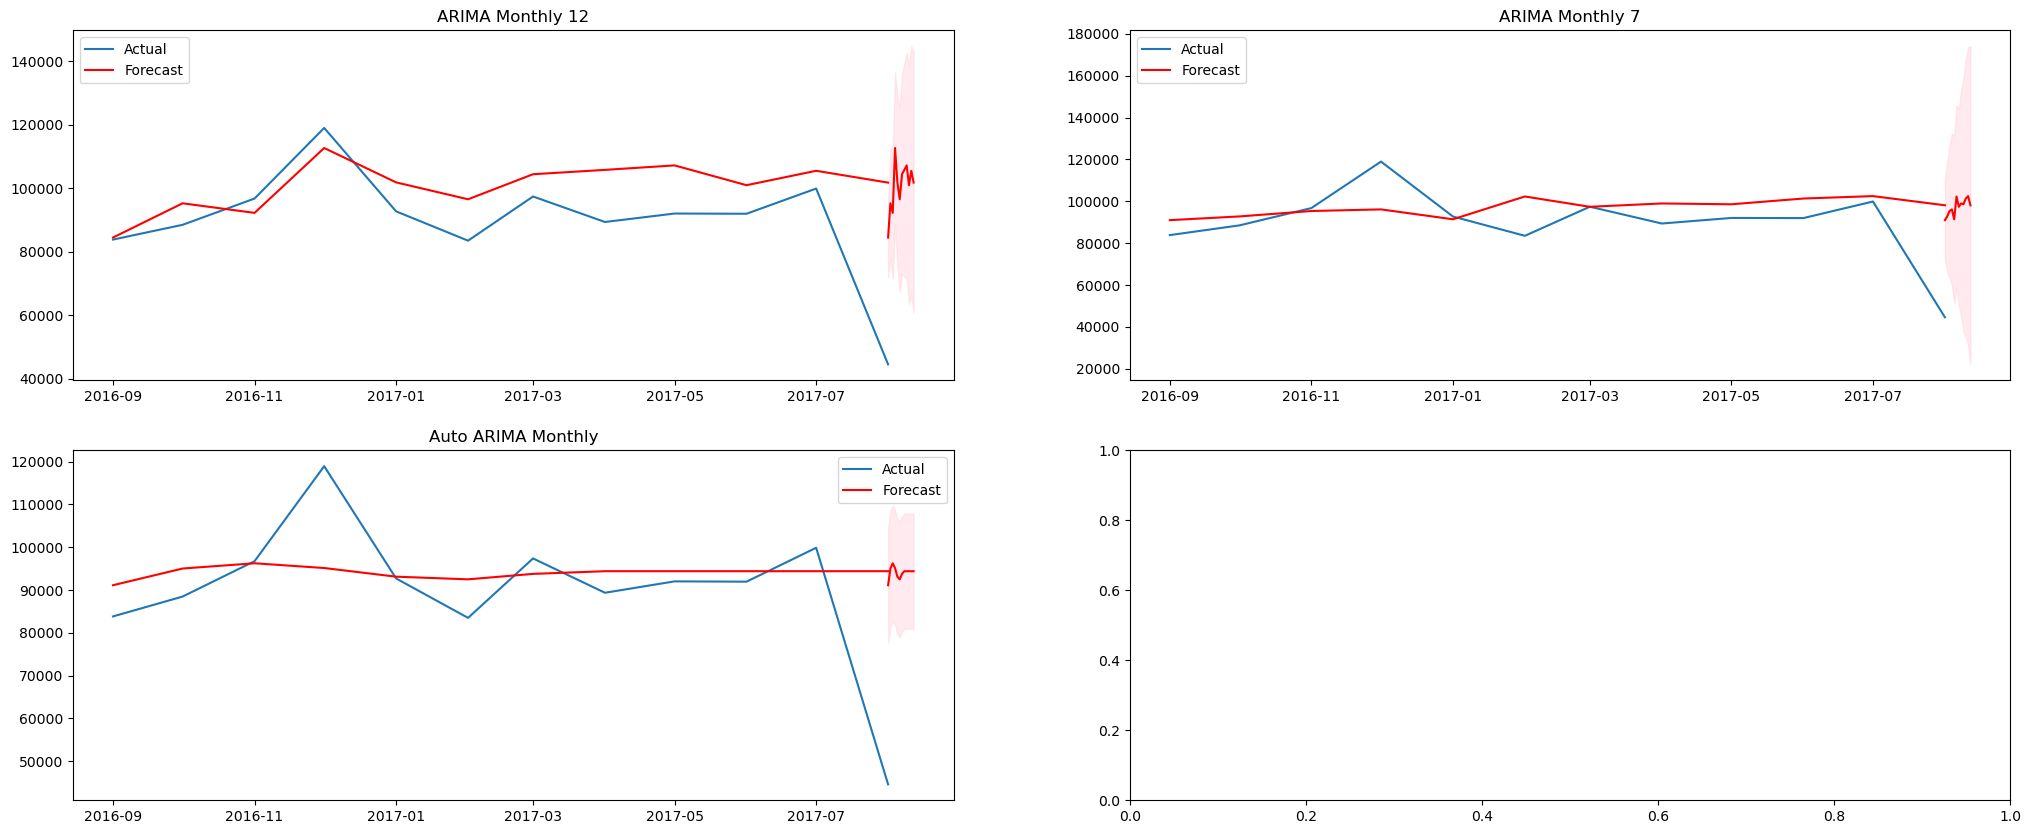

In [245]:
no_month = 12



forecast_arima_monthly_12 = model_fit_arima_monthly_12.get_forecast(steps=no_month) 
forecast_values_arima_monthly_12 = forecast_arima_monthly_12.predicted_mean
confidence_intervals_arima_monthly_12 = forecast_arima_monthly_12.conf_int()

forecast_arima_monthly_7 = model_fit_arima_monthly_7.get_forecast(steps=no_month) 
forecast_values_arima_monthly_7 = forecast_arima_monthly_7.predicted_mean
confidence_intervals_arima_monthly_7 = forecast_arima_monthly_7.conf_int()

# hybrid average 365 & 7
# forecast_arima_daily_hybrid = (forecast_arima_daily_365+forecast_arima_daily_7)/2

forecast_auto_arima_monthly = pd.DataFrame(auto_arima_monthly.predict(n_periods=no_month))
forecast_values_auto_arima_monthly = forecast_auto_arima_monthly
confidence_intervals_auto_arima_monthly = np.column_stack([
    forecast_values_auto_arima_monthly - 1.96 * auto_arima_monthly.resid().std(),
    forecast_values_auto_arima_monthly + 1.96 * auto_arima_monthly.resid().std()
])




# forecast_LSTM_daily = model_LSTM_daily.predict(actual)
# forecast_values_LSTM_daily = forecast_LSTM_daily
# confidence_intervals_LSTM_daily = np.column_stack([
#     forecast_values_LSTM_daily - 1.96 * predict_LSTM_daily.resid().std(),
#     forecast_values_LSTM_daily + 1.96 * predict_LSTM_daily.resid().std()
# ])


fig, ax = plt.subplots(2, 2, figsize=(25, 10))
ax[0,0].plot(test_monthly.index, test_monthly["Sales"], label="Actual")
ax[0,0].plot(pd.date_range(test_monthly.index[-1], periods=no_month, freq="D"), forecast_values_arima_monthly_12, label="Forecast", color="red")
ax[0,0].plot(predict_arima_monthly_12, color='red')
ax[0,0].set_title('ARIMA Monthly 12')
ax[0,0].fill_between(pd.date_range(test_monthly.index[-1], periods=no_month, freq="D"), confidence_intervals_arima_monthly_12.iloc[:,0], confidence_intervals_arima_monthly_12.iloc[:,1], color="pink", alpha=0.3)
ax[0,0].legend()

ax[0,1].plot(test_monthly.index, test_monthly["Sales"], label="Actual")
ax[0,1].plot(pd.date_range(test_monthly.index[-1], periods=no_month, freq="D"), forecast_values_arima_monthly_7, label="Forecast", color="red")
ax[0,1].plot(predict_arima_monthly_7, color='red')
ax[0,1].set_title('ARIMA Monthly 7')
ax[0,1].fill_between(pd.date_range(test_monthly.index[-1], periods=no_month, freq="D"), confidence_intervals_arima_monthly_7.iloc[:,0], confidence_intervals_arima_monthly_7.iloc[:,1], color="pink", alpha=0.3)
ax[0,1].legend()

ax[1,0].plot(test_monthly.index, test_monthly["Sales"], label="Actual")
ax[1,0].plot(pd.date_range(test_monthly.index[-1], periods=no_month, freq="D"), forecast_values_auto_arima_monthly, label="Forecast", color="red")
ax[1,0].plot(predict_auto_arima_monthly, color='red')
ax[1,0].set_title('Auto ARIMA Monthly')
ax[1,0].fill_between(pd.date_range(test_monthly.index[-1], periods=no_month, freq="D"), confidence_intervals_auto_arima_monthly[:,0], confidence_intervals_auto_arima_monthly[:,1], color="pink", alpha=0.3)
ax[1,0].legend()

# ax[1,1].plot(test_daily.index, test_daily["Sales"], label="Actual")
# ax[1,1].plot(pd.date_range(test_daily.index[-1], periods=1000, freq="D"), forecast_LSTM_daily, label="Forecast", color="red")
# ax[1,1].set_title('LSTM')
# ax[1,1].fill_between(pd.date_range(test_daily.index[-1], periods=1000, freq="D"), confidence_intervals_auto_arima_daily[:,0], confidence_intervals_auto_arima_daily[:,1], color="pink", alpha=0.3)
# ax[1,1].legend()

# Forecasting The Best Model (Optional)

In [ ]:
# x_input = scaled_test_daily[-n_input_daily:]

# forecast = []

# for _ in range(no_days):

#     yhat = model_LSTM_daily.predict(x_input)
#     forecast.append(yhat)
#     x_input = np.append(x_input[1:], yhat).reshape(1, n_input_daily, 1)


# forecast

In [ ]:
# forecast_LSTM_daily = []

# # Use the last known data as the starting input
# x_input = scaled_test_daily[-10:].reshape(n_input_daily, n_features_daily)  # Ensure shape is (1, time_steps, features)
# model_LSTM_daily = Sequential([
#     LSTM(50, return_sequences=True, input_shape=(n_input_daily, n_features_daily)),
#     LSTM(50),
#     Dense(1)
# ])


# for _ in range(100):  # Forecast 'no_days' future steps
#     next_value = model_LSTM_daily.predict(scaled_test_daily[-10:])
#     forecast_LSTM_daily.append(next_value[0, 0])  # Store scalar value

#     # Update input by appending the new prediction and shifting the sequence
#     x_input = np.append(x_input[0, 1:], next_value).reshape(1, 10, 1)

# # Convert list to NumPy array
# forecast_LSTM_daily = np.array(forecast_LSTM_daily)


In [ ]:
# # Define the number of future time steps to forecast
# n_forecast_steps = 10  # Adjust as needed

# # Get the last available sequence from test data for forecasting
# last_sequence = scaled_test_daily[-n_input_daily:]
# last_sequence = last_sequence.reshape((n_input_daily, n_features_daily))



# # Initialize list to store predictions
# future_predictions = []

# # Forecast iteratively
# for _ in range(n_forecast_steps):
#     next_pred = model_LSTM_daily.predict(last_sequence)
#     future_predictions.append(next_pred[0,0])  # Store predicted value
    
#     # Update the sequence: remove first element, append the latest prediction
#     last_sequence = np.append(last_sequence[1:, :], [[next_pred]], axis=1)

# # Inverse transform predictions to original scale
# future_predictions = np.array(future_predictions).reshape(-1, 1)
# future_predictions = scaler_daily.inverse_transform(future_predictions)

# # Generate a corresponding date index for plotting (assuming test_daily has a datetime index)
# future_dates = pd.date_range(start=test_daily.index[-1], periods=n_forecast_steps+1, freq='D')[1:]

# # Create DataFrame for visualization
# forecast_df = pd.DataFrame({'Date': future_dates, 'Predicted Values': future_predictions.flatten()})
# forecast_df.set_index('Date', inplace=True)

# # Plot actual values vs forecasted values

# plt.figure(figsize=(10, 5))
# plt.plot(test_daily.index, testactual_daily, label="Actual", color="blue")
# plt.plot(forecast_df.index, forecast_df["Predicted Values"], label="Forecast", linestyle='dashed', color="red")
# plt.xlabel("Date")
# plt.ylabel("Value")
# plt.title("LSTM Forecasting Results")
# plt.legend()
# plt.show()




In [ ]:
# print(f"Shape of last_sequence: {last_sequence.shape}")

In [ ]:
# df_test_daily = pd.DataFrame(test_daily)
# start_index_LSTM_daily = df_test_daily.index[0]
# periods_LSTM_daily = len(test_daily) + no_days

# date = pd.date_range(start=start_index_LSTM_daily, periods=periods_LSTM_daily, freq="D")

# forecast_LSTM_daily = pd.DataFrame(model_LSTM_daily.predict(scaled_test_daily))[:periods_LSTM_daily]
# forecast_LSTM_daily = scaler_daily.inverse_transform(forecast_LSTM_daily)
# forecast_LSTM_daily = forecast_LSTM_daily.reshape(-1,1)
# forecast_LSTM_daily = pd.DataFrame(forecast_LSTM_daily)



11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


<Axes: >

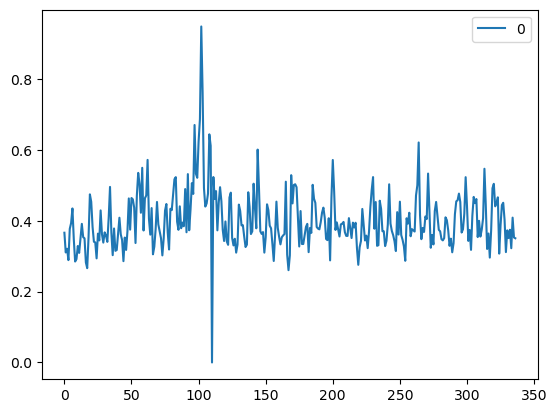

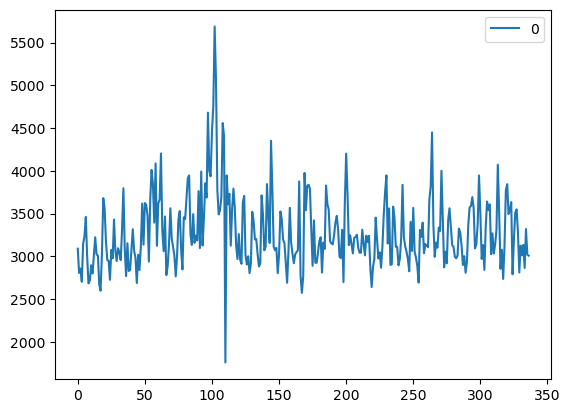

In [ ]:
# testtest = pd.DataFrame(scaled_test_daily)
# testtest.plot()

# forecast_LSTM_daily.plot()

In [ ]:
# forecast_LSTM_daily

0
0    3090.497314
1    2806.460693
2    2858.626221
3    2703.159668
4    3148.015381
..           ...
332  3134.952393
333  2865.692383
334  3319.466553
335  3020.191650
336  3008.803223

[337 rows x 1 columns]